## Description
This script is intended to do *primarily* the same as in CouplingIndex_ModelVersionSensitivity, but is cleaned up to handle only daily data (now that we have that accessible for CAM5+CLM5), and features a more intense investigation into which changes in CLM5 are responsible for the decrease in coupling strength via 5-year sensitivity tests. 
<br><br>
Date: 16 Feb 2021

In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
#import regionmask
#from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


In [2]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


## Read in CI data

In [142]:
# Load in pickle files: 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'


In [143]:
## Read in CESM2 data ( CAM6 + CLM5 )

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_1979-2006.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_1979-2006.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_1979-2006.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM6wCLM5  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM6wCLM5 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM6wCLM5  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

lat = atmoLeg_CAM6wCLM5.lat.values
lon = atmoLeg_CAM6wCLM5.lon.values


In [144]:
## Read in CESM1 data ( CAM5 + CLM4 )

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM1.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM1.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM1.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM5wCLM4  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM5wCLM4 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM5wCLM4  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


In [145]:
## Read in CAM6 + CLM4.5 data 

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM6wCLM45  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM6wCLM45 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM6wCLM45  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


In [146]:
## Read in CAM5 + CLM5 data 

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CAM5-CLM5.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CAM5-CLM5.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CAM5-CLM5.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM5wCLM5  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM5wCLM5 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM5wCLM5  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


## Plot some comparisons! 
Start off with maps

In [147]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)


### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)


In [148]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
AtmoLeg_JJA_cesm1  = np.squeeze(np.asarray(atmoLeg_CAM5wCLM4.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm1 = np.squeeze(np.asarray(terraLeg_CAM5wCLM4.soilM_10_SHFLX_CI[1,:,:]))

AtmoLeg_JJA_cesm2  = np.squeeze(np.asarray(atmoLeg_CAM6wCLM5.hfss_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm2 = np.squeeze(np.asarray(terraLeg_CAM6wCLM5.mrsos_hfss_CI[1,:,:]))

AtmoLeg_JJA_clm45  = np.squeeze(np.asarray(atmoLeg_CAM6wCLM45.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm45 = np.squeeze(np.asarray(terraLeg_CAM6wCLM45.soilM_10_SHFLX_CI[1,:,:]))

AtmoLeg_JJA_cam5   = np.squeeze(np.asarray(atmoLeg_CAM5wCLM5.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_cam5  = np.squeeze(np.asarray(terraLeg_CAM5wCLM5.soilM_10_SHFLX_CI[1,:,:]))

# Make cyclic first 
AtmoLeg_JJA_cyclic_cesm1, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm1, lon)
TerraLeg_JJA_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm1, lon)
AtmoLeg_JJA_cyclic_cesm2, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm2, lon)
TerraLeg_JJA_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm2, lon)
AtmoLeg_JJA_cyclic_clm45, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_clm45, lon)
TerraLeg_JJA_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_clm45, lon)
AtmoLeg_JJA_cyclic_cam5, lon_cyclic   = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cam5, lon)
TerraLeg_JJA_cyclic_cam5, lon_cyclic  = cartopy.util.add_cyclic_point(TerraLeg_JJA_cam5, lon)

# Now get color coded arrays 
colorsAtmoLeg_cesm1  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cesm2  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_clm45  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cam5   = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cam5  = np.full([len(lat),len(lon)+1],np.nan)

# ----- CESM 1 ------

# Atmo leg 
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1<-150)]                                 = 1
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-150) & (AtmoLeg_JJA_cyclic_cesm1<=-100))]  = 2
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-100) & (AtmoLeg_JJA_cyclic_cesm1<=-50))]   = 3
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-50)  & (AtmoLeg_JJA_cyclic_cesm1<=-20))]   = 4
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-20)  & (AtmoLeg_JJA_cyclic_cesm1<=0))]     = 5
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>0)    & (AtmoLeg_JJA_cyclic_cesm1<=20))]    = 6
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>20)   & (AtmoLeg_JJA_cyclic_cesm1<=40))]    = 7
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>40)   & (AtmoLeg_JJA_cyclic_cesm1<=60))]    = 8
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>60)   & (AtmoLeg_JJA_cyclic_cesm1<=80))]    = 9
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>80)   & (AtmoLeg_JJA_cyclic_cesm1<=100))]   = 10
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1<-20)]                                 = 1
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-20) & (TerraLeg_JJA_cyclic_cesm1<=-15))]  = 2
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-15) & (TerraLeg_JJA_cyclic_cesm1<=-10))]  = 3
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-10) & (TerraLeg_JJA_cyclic_cesm1<=-5))]   = 4
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-5) & (TerraLeg_JJA_cyclic_cesm1<=-2))]    = 5
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-2) & (TerraLeg_JJA_cyclic_cesm1<=-1))]    = 6
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-1) & (TerraLeg_JJA_cyclic_cesm1<=0))]     = 7
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1>0)]                                   = 8


# ----- CESM 2 ------

# Atmo leg 
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2<-150)]                                 = 1
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-150) & (AtmoLeg_JJA_cyclic_cesm2<=-100))]  = 2
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-100) & (AtmoLeg_JJA_cyclic_cesm2<=-50))]   = 3
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-50)  & (AtmoLeg_JJA_cyclic_cesm2<=-20))]   = 4
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-20)  & (AtmoLeg_JJA_cyclic_cesm2<=0))]     = 5
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>0)    & (AtmoLeg_JJA_cyclic_cesm2<=20))]    = 6
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>20)   & (AtmoLeg_JJA_cyclic_cesm2<=40))]    = 7
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>40)   & (AtmoLeg_JJA_cyclic_cesm2<=60))]    = 8
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>60)   & (AtmoLeg_JJA_cyclic_cesm2<=80))]    = 9
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>80)   & (AtmoLeg_JJA_cyclic_cesm2<=100))]   = 10
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2<-20)]                                 = 1
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-20) & (TerraLeg_JJA_cyclic_cesm2<=-15))]  = 2
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-15) & (TerraLeg_JJA_cyclic_cesm2<=-10))]  = 3
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-10) & (TerraLeg_JJA_cyclic_cesm2<=-5))]   = 4
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-5) & (TerraLeg_JJA_cyclic_cesm2<=-2))]    = 5
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-2) & (TerraLeg_JJA_cyclic_cesm2<=-1))]    = 6
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-1) & (TerraLeg_JJA_cyclic_cesm2<=0))]     = 7
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2>0)]                                   = 8



# ----- CLM4.5 ------

# Atmo leg 
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45<-150)]                                 = 1
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-150) & (AtmoLeg_JJA_cyclic_clm45<=-100))]  = 2
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-100) & (AtmoLeg_JJA_cyclic_clm45<=-50))]   = 3
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-50)  & (AtmoLeg_JJA_cyclic_clm45<=-20))]   = 4
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-20)  & (AtmoLeg_JJA_cyclic_clm45<=0))]     = 5
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>0)    & (AtmoLeg_JJA_cyclic_clm45<=20))]    = 6
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>20)   & (AtmoLeg_JJA_cyclic_clm45<=40))]    = 7
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>40)   & (AtmoLeg_JJA_cyclic_clm45<=60))]    = 8
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>60)   & (AtmoLeg_JJA_cyclic_clm45<=80))]    = 9
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>80)   & (AtmoLeg_JJA_cyclic_clm45<=100))]   = 10
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45>100)]                                  = 11


# Terra leg  
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45<-20)]                                 = 1
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-20) & (TerraLeg_JJA_cyclic_clm45<=-15))]  = 2
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-15) & (TerraLeg_JJA_cyclic_clm45<=-10))]  = 3
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-10) & (TerraLeg_JJA_cyclic_clm45<=-5))]   = 4
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-5) & (TerraLeg_JJA_cyclic_clm45<=-2))]    = 5
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-2) & (TerraLeg_JJA_cyclic_clm45<=-1))]    = 6
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-1) & (TerraLeg_JJA_cyclic_clm45<=0))]     = 7
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45>0)]                                   = 8



# ----- CAM5 ------

# Atmo leg 
colorsAtmoLeg_cam5[np.where(AtmoLeg_JJA_cyclic_cam5<-150)]                                 = 1
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-150) & (AtmoLeg_JJA_cyclic_cam5<=-100))]  = 2
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-100) & (AtmoLeg_JJA_cyclic_cam5<=-50))]   = 3
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-50)  & (AtmoLeg_JJA_cyclic_cam5<=-20))]   = 4
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-20)  & (AtmoLeg_JJA_cyclic_cam5<=0))]     = 5
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>0)    & (AtmoLeg_JJA_cyclic_cam5<=20))]    = 6
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>20)   & (AtmoLeg_JJA_cyclic_cam5<=40))]    = 7
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>40)   & (AtmoLeg_JJA_cyclic_cam5<=60))]    = 8
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>60)   & (AtmoLeg_JJA_cyclic_cam5<=80))]    = 9
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>80)   & (AtmoLeg_JJA_cyclic_cam5<=100))]   = 10
colorsAtmoLeg_cam5[np.where(AtmoLeg_JJA_cyclic_cam5>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cam5[np.where(TerraLeg_JJA_cyclic_cam5<-20)]                                 = 1
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-20) & (TerraLeg_JJA_cyclic_cam5<=-15))]  = 2
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-15) & (TerraLeg_JJA_cyclic_cam5<=-10))]  = 3
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-10) & (TerraLeg_JJA_cyclic_cam5<=-5))]   = 4
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-5) & (TerraLeg_JJA_cyclic_cam5<=-2))]    = 5
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-2) & (TerraLeg_JJA_cyclic_cam5<=-1))]    = 6
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-1) & (TerraLeg_JJA_cyclic_cam5<=0))]     = 7
colorsTerraLeg_cam5[np.where(TerraLeg_JJA_cyclic_cam5>0)]                                   = 8



In [149]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask = np.full([len(lat),len(lon)+1],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_JJA_cyclic_cesm1))] = 1


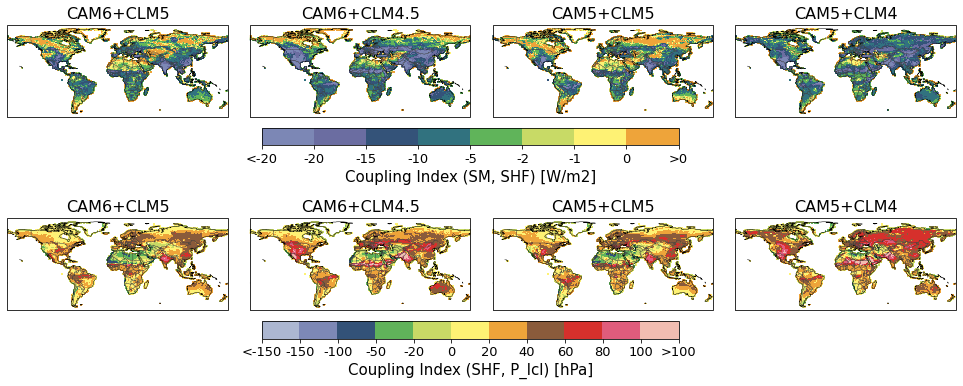

In [11]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CAM6+CLM5',fontsize=16)
axs[4].set_title('CAM6+CLM5',fontsize=16)
# axs[0].gridlines()
# axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsTerraLeg_clm45,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=13)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_clm45*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=15)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=13)  # vertically oriented colorbar


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[5].set_title('CAM6+CLM4.5',fontsize=16)
# axs[1].gridlines()
# axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cam5,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[6].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cam5*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[6].set_title('CAM5+CLM5',fontsize=16)
# axs[2].gridlines()
# axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm1,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm1*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[3].set_title('CAM5+CLM4',fontsize=16)
axs[7].set_title('CAM5+CLM4',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


### Difference plots

In [150]:
atmoDiff_CESM2vCESM1 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_cesm1  # Impact of upgrading CAM and CLM 
atmoDiff_CESM2vCLM45 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_clm45  # Impact of upgrading CAM 
atmoDiff_CESM2vCAM5  = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_cam5   # Impact of upgrading CLM 

terraDiff_CESM2vCESM1 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_cesm1 # Impact of upgrading CAM and CLM  
terraDiff_CESM2vCLM45 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_clm45 # Impact of upgrading CAM 
terraDiff_CESM2vCAM5  = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_cam5  # Impact of upgrading CLM 


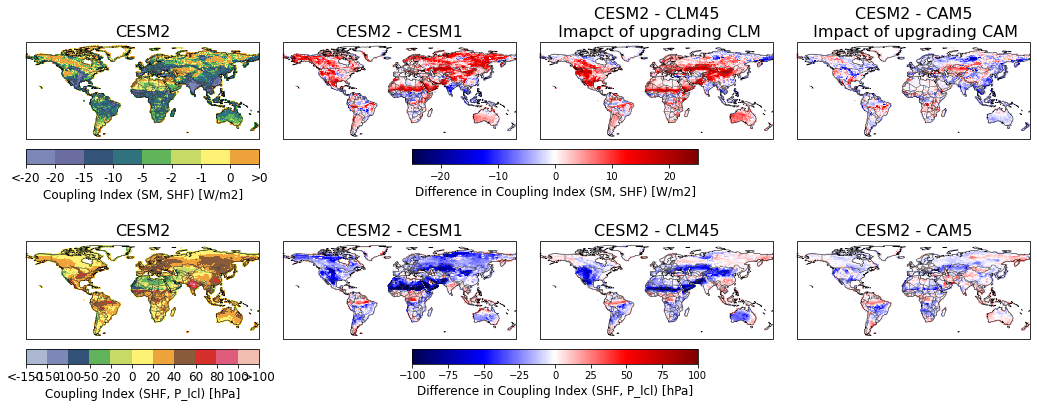

In [13]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(18, 7), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=12)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=12)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=12)  # vertically oriented colorbar


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
# axs[0].gridlines()
# axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-25,vmax=25)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.1, ax_position.y0-0.05, ax_position.width+0.04, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SM, SHF) [W/m2]',fontsize=12)

contour_plot = axs[5].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.1, ax_position.y0-0.05, ax_position.width+0.04, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
# axs[1].gridlines()
# axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-25,vmax=25)

contour_plot = axs[6].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
# axs[2].gridlines()
# axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot impact of upgrading just CAM------ 
#   ...Diff_CESM2vCAM5
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCAM5,
                             cmap='seismic',
                             vmin=-25,vmax=25)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCAM5*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[7].set_title('CESM2 - CAM5',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Add star point 
# axs[6].plot(lon[100],lat[170],'k*',markersize=12,transform=ccrs.PlateCarree())
# axs[7].plot(lon[100],lat[170],'k*',markersize=12,transform=ccrs.PlateCarree())


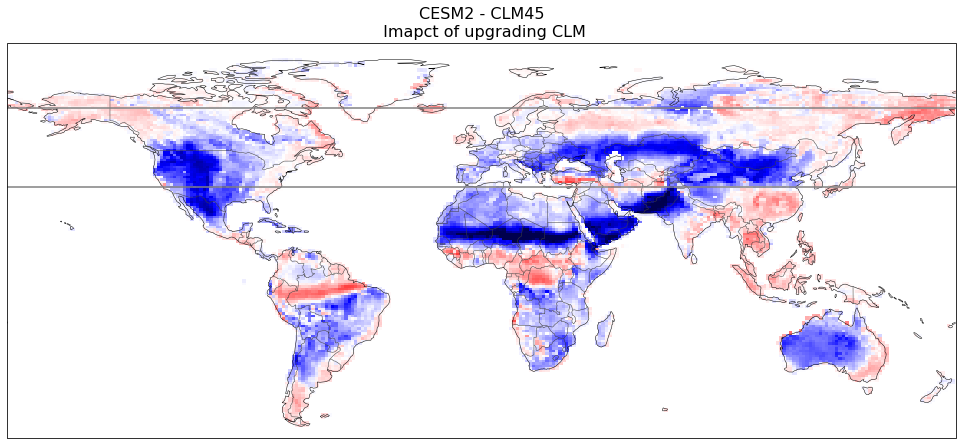

In [156]:
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Set global-ish extent
ax1.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
# contour_plot = ax1.pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
#                              cmap='seismic',
#                              vmin=-25,vmax=25)

contour_plot = ax1.pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
ax1.set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
# axs[2].gridlines()
# axs[6].gridlines()
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax1.axhline(35,color='grey')
ax1.axhline(65,color='grey')



### Zonal Means

In [11]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask_notCyclic = np.full([len(lat),len(lon)],np.nan)
lndMask_notCyclic[np.where(np.isfinite(TerraLeg_JJA_cesm1))] = 1


In [12]:
# Use a simple moving average over latitude to smooth out zonal means
#  Method here: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
#  Left centered moving average (i.e., latitude mean assigned to lowest value is mean of that value and next two)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w



Latitude diff aroud:  2.8272251308900564 ˚


<ipython-input-18-164aacd9e70a>:3: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
<ipython-input-18-164aacd9e70a>:4: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_JJA_cesm1*lndMask_notCyclic,axis=1)
<ipython-input-18-164aacd9e70a>:5: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)
<ipython-input-18-164aacd9e70a>:6: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CAM5  = np.nanmean(AtmoLeg_JJA_cam5*lndMask_notCyclic, axis=1)
<ipython-input-18-164aacd9e70a>:10: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_JJA_cesm2, axis=1)
<ipython-input-18-164aacd9e70a>:11: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CESM1 = np.nanmean(TerraLeg_JJA_cesm1, axis=1)
<ipython-input-18-164aacd9e70a>:12: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CLM45 = np.nanmean(TerraL

(-20.0, 4.0)

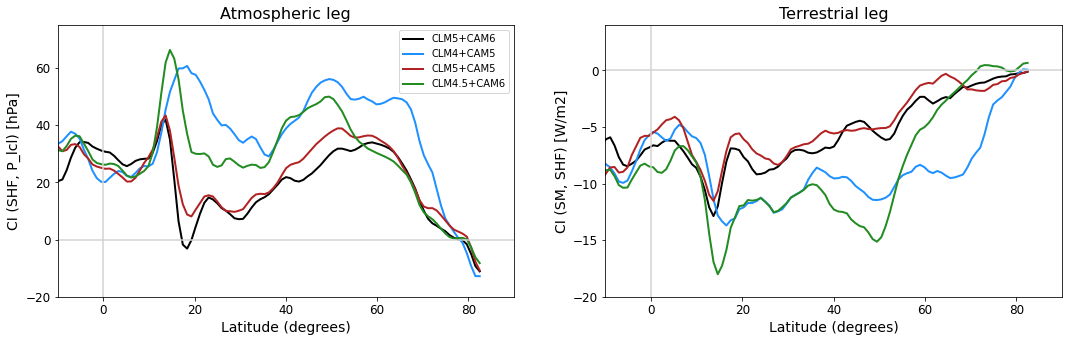

In [18]:
# Atmospheric leg of CI 

lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_JJA_cesm1*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CAM5  = np.nanmean(AtmoLeg_JJA_cam5*lndMask_notCyclic, axis=1)

# Terrestrial leg of CI 

lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_JJA_cesm2, axis=1)
lonMean_terraLeg_CESM1 = np.nanmean(TerraLeg_JJA_cesm1, axis=1)
lonMean_terraLeg_CLM45 = np.nanmean(TerraLeg_JJA_clm45, axis=1)
lonMean_terraLeg_CAM5  = np.nanmean(TerraLeg_JJA_cam5,  axis=1)

w = 3    # Number of latitudes to compute window over (~2.5-3˚)
print('Latitude diff aroud: ', (lat[80] - lat[80-w]), '˚')

lonMean_atmoLeg_CESM2            = moving_average(lonMean_atmoLeg_CESM2, w)
lonMean_atmoLeg_CESM1            = moving_average(lonMean_atmoLeg_CESM1, w)
lonMean_atmoLeg_CLM45            = moving_average(lonMean_atmoLeg_CLM45, w)
lonMean_atmoLeg_CAM5             = moving_average(lonMean_atmoLeg_CAM5, w)

lonMean_terraLeg_CESM2           = moving_average(lonMean_terraLeg_CESM2, w)
lonMean_terraLeg_CESM1           = moving_average(lonMean_terraLeg_CESM1, w)
lonMean_terraLeg_CLM45           = moving_average(lonMean_terraLeg_CLM45, w)
lonMean_terraLeg_CAM5            = moving_average(lonMean_terraLeg_CAM5, w)

smoothLat = moving_average(lat,w)

# --- Plot atmospheric leg ---- 

# Now plot that 
fig, axs = plt.subplots(1,2, figsize=(18, 5))
axs = axs.ravel()

axs[0].plot(smoothLat,lonMean_atmoLeg_CESM2,'k',linewidth=2,label='CLM5+CAM6')
axs[0].plot(smoothLat,lonMean_atmoLeg_CESM1,'dodgerblue',linewidth=2,label='CLM4+CAM5')
axs[0].plot(smoothLat,lonMean_atmoLeg_CAM5,'firebrick',linewidth=2,label='CLM5+CAM5')
axs[0].plot(smoothLat,lonMean_atmoLeg_CLM45,'forestgreen',linewidth=2,label='CLM4.5+CAM6')

axs[0].legend()
axs[0].set_xlabel('Latitude (degrees)',fontsize=14)
axs[0].set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=14)
axs[0].set_title('Atmospheric leg',fontsize=16)
axs[0].set_xlim([-10, 90])
axs[0].axhline(0,color='lightgrey')
axs[0].axvline(0,color='lightgrey')

# --- Plot terrestrial leg ---- 
axs[1].plot(smoothLat,lonMean_terraLeg_CESM2,'k',linewidth=2)
axs[1].plot(smoothLat,lonMean_terraLeg_CESM1,'dodgerblue',linewidth=2)
axs[1].plot(smoothLat,lonMean_terraLeg_CAM5,'firebrick',linewidth=2)
axs[1].plot(smoothLat,lonMean_terraLeg_CLM45,'forestgreen',linewidth=2)

axs[1].set_xlabel('Latitude (degrees)',fontsize=14)
axs[1].set_ylabel('CI (SM, SHF) [W/m2]',fontsize=14)
axs[1].set_title('Terrestrial leg',fontsize=16)
axs[1].set_xlim([-10, 90])
axs[1].axhline(0,color='lightgrey')
axs[1].axvline(0,color='lightgrey')

axs[0].tick_params(axis='both',labelsize=12)
axs[1].tick_params(axis='both',labelsize=12)
axs[0].set_ylim([-20,75])
axs[1].set_ylim([-20,4])


<ipython-input-164-3defe3411865>:19: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_DJF_cesm2*lndMask_notCyclic,axis=1)
<ipython-input-164-3defe3411865>:20: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_DJF_cesm1*lndMask_notCyclic,axis=1)
<ipython-input-164-3defe3411865>:21: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_DJF_clm45*lndMask_notCyclic,axis=1)
<ipython-input-164-3defe3411865>:22: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CAM5  = np.nanmean(AtmoLeg_DJF_cam5*lndMask_notCyclic, axis=1)
<ipython-input-164-3defe3411865>:26: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_DJF_cesm2, axis=1)
<ipython-input-164-3defe3411865>:27: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CESM1 = np.nanmean(TerraLeg_DJF_cesm1, axis=1)
<ipython-input-164-3defe3411865>:28: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CLM45 = np.nan

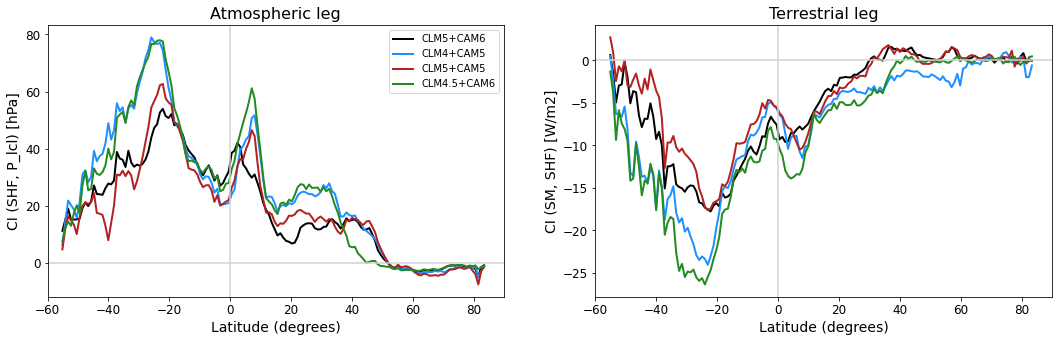

In [164]:
# # ----- DJF check ------
# # ----------------------

# # Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
# AtmoLeg_DJF_cesm1  = np.squeeze(np.asarray(atmoLeg_CAM5wCLM4.SHFLX_Plcl_CI[0,:,:]))
# TerraLeg_DJF_cesm1 = np.squeeze(np.asarray(terraLeg_CAM5wCLM4.soilM_10_SHFLX_CI[0,:,:]))

# AtmoLeg_DJF_cesm2  = np.squeeze(np.asarray(atmoLeg_CAM6wCLM5.hfss_Plcl_CI[0,:,:]))
# TerraLeg_DJF_cesm2 = np.squeeze(np.asarray(terraLeg_CAM6wCLM5.mrsos_hfss_CI[0,:,:]))

# AtmoLeg_DJF_clm45  = np.squeeze(np.asarray(atmoLeg_CAM6wCLM45.SHFLX_Plcl_CI[0,:,:]))
# TerraLeg_DJF_clm45 = np.squeeze(np.asarray(terraLeg_CAM6wCLM45.soilM_10_SHFLX_CI[0,:,:]))

# AtmoLeg_DJF_cam5   = np.squeeze(np.asarray(atmoLeg_CAM5wCLM5.SHFLX_Plcl_CI[0,:,:]))
# TerraLeg_DJF_cam5  = np.squeeze(np.asarray(terraLeg_CAM5wCLM5.soilM_10_SHFLX_CI[0,:,:]))

# # Atmospheric leg of CI 

# lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_DJF_cesm2*lndMask_notCyclic,axis=1)
# lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_DJF_cesm1*lndMask_notCyclic,axis=1)
# lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_DJF_clm45*lndMask_notCyclic,axis=1)
# lonMean_atmoLeg_CAM5  = np.nanmean(AtmoLeg_DJF_cam5*lndMask_notCyclic, axis=1)

# # Terrestrial leg of CI 

# lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_DJF_cesm2, axis=1)
# lonMean_terraLeg_CESM1 = np.nanmean(TerraLeg_DJF_cesm1, axis=1)
# lonMean_terraLeg_CLM45 = np.nanmean(TerraLeg_DJF_clm45, axis=1)
# lonMean_terraLeg_CAM5  = np.nanmean(TerraLeg_DJF_cam5,  axis=1)

# # --- Plot atmospheric leg ---- 

# # Now plot that 
# fig, axs = plt.subplots(1,2, figsize=(18, 5))
# axs = axs.ravel()

# axs[0].plot(lat,lonMean_atmoLeg_CESM2,'k',linewidth=2,label='CLM5+CAM6')
# axs[0].plot(lat,lonMean_atmoLeg_CESM1,'dodgerblue',linewidth=2,label='CLM4+CAM5')
# axs[0].plot(lat,lonMean_atmoLeg_CAM5,'firebrick',linewidth=2,label='CLM5+CAM5')
# axs[0].plot(lat,lonMean_atmoLeg_CLM45,'forestgreen',linewidth=2,label='CLM4.5+CAM6')

# axs[0].legend()
# axs[0].set_xlabel('Latitude (degrees)',fontsize=14)
# axs[0].set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=14)
# axs[0].set_title('Atmospheric leg',fontsize=16)
# axs[0].set_xlim([-60, 90])
# axs[0].axhline(0,color='lightgrey')
# axs[0].axvline(0,color='lightgrey')

# # --- Plot terrestrial leg ---- 
# axs[1].plot(lat,lonMean_terraLeg_CESM2,'k',linewidth=2)
# axs[1].plot(lat,lonMean_terraLeg_CESM1,'dodgerblue',linewidth=2)
# axs[1].plot(lat,lonMean_terraLeg_CAM5,'firebrick',linewidth=2)
# axs[1].plot(lat,lonMean_terraLeg_CLM45,'forestgreen',linewidth=2)

# axs[1].set_xlabel('Latitude (degrees)',fontsize=14)
# axs[1].set_ylabel('CI (SM, SHF) [W/m2]',fontsize=14)
# axs[1].set_title('Terrestrial leg',fontsize=16)
# axs[1].set_xlim([-60, 90])
# axs[1].axhline(0,color='lightgrey')
# axs[1].axvline(0,color='lightgrey')

# axs[0].tick_params(axis='both',labelsize=12)
# axs[1].tick_params(axis='both',labelsize=12)
# # axs[0].set_ylim([-20,75])
# # axs[1].set_ylim([-20,4])



# Question: Which change in CLM5 is driving the shift in CI?
To assess this, running a series of 5-year tests on Cheyenne with different parameters turned off. <br>
* Dry surface layer set back to CLM4.5 usage 
* Plant hydraulic stress formulation turned off 
* Fraction of preciption intercepted set to CLM4.5 value 
* Soil layer structure and rooting profile method for water set back to CLM4.5 value 

## Get CESM2 (CAM6+CLM5) and CAM6+CLM4.5 CI over just the five year test periods

In [157]:
# Set directories and file names 
dailyDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/'
#dailyDir   = '/glade/work/mdfowler/data/CESM2/'
middleName = '_day_CESM2_amip_r10i1p1f1_gn_'
varNames   = ['hfls','hfss','mrso','mrsos','tas','hurs','ps']

# Set time period portion of fileNames 
# timeName_flx  = ['19500101-19591231','19600101-19691231','19700101-19791231','19800101-19891231', 
#                  '19900101-19991231','20000101-20091231','20100101-20150101']
timeName_flx  = ['19700101-19791231','19800101-19891231']

timeName_soil = ['19500101-19991231']


In [158]:
for iT in range(len(timeName_flx)):

    # --- Compile surface fluxes into singe large arrays in time 
    
    # Sensible heat flux
    shFile       = dailyDir+varNames[1]+middleName+timeName_flx[iT]+'.nc' # File name
    shDF         = xr.open_dataset(shFile,decode_times=True)
    shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    if iT==0:
        shflx_full = shDF
    else: 
        shflx_full = xr.concat([shflx_full, shDF], dim="time")


    print('Done with ', timeName_flx[iT])



/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
<ipython-input-158-2e625d85832a>:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


Done with  19700101-19791231
Done with  19800101-19891231


In [159]:
# Read in soil moisture

for iT in range(len(timeName_soil)):

    # --- Compile soil moisture into singe large arrays in time 
    
    # 10 cm SM 
    soil10File = dailyDir+varNames[3]+middleName+timeName_soil[iT]+'.nc' # File name
    soil10DF   = xr.open_dataset(soil10File,decode_times=True)
    soil10DF['time'] = soil10DF.indexes['time'].to_datetimeindex()
    
    if iT==0:
        soilM10_full = soil10DF
    else: 
        soilM10_full = xr.concat([soilM10_full, soil10DF], dim="time")

    print('Done with ', timeName_soil[iT])
    

/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Done with  19500101-19991231


<ipython-input-159-d0f9bc4c091f>:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  soil10DF['time'] = soil10DF.indexes['time'].to_datetimeindex()


In [160]:
lat = soilM10_full.lat.values
lon = soilM10_full.lon.values

In [161]:
# Load pressure level of LCL (computed separately in Get_LCLpressure.py and saved as pickle file)
#lclPath = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_1970-2014.p'
lclPath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_1970-2014.p'

Plcl    = pickle.load( open( lclPath, "rb" ) )


In [162]:
# Limit time period of soil moisture: 
dates       = pd.DatetimeIndex(soilM10_full['time'].values)
iIncludeSM  = np.where((dates.year>=1979) & (dates.year<=1983))[0]
soilM10_sel = np.asarray(soilM10_full.mrsos.values)[iIncludeSM,:,:]

# Now limit the time period of everything else 
dates     = pd.DatetimeIndex(shflx_full['time'].values)
iInclude  = np.where((dates.year>=1979) & (dates.year<=1983))[0]
dates     = dates[iInclude]

SHflx_sel = shflx_full.isel(time=iInclude)
Plcl_sel  = Plcl[iInclude,:,:]


In [163]:
# Remove bigger arrays from memory (see if we can save some space)
del shflx_full


In [164]:
# Make one big xr.Dataset containing all the information we need  
dFull = SHflx_sel
dFull['mrsos'] = (('time','lat','lon'), soilM10_sel)
dFull['Plcl']  = (('time','lat','lon'), Plcl_sel)


In [165]:
terraLeg_couplingCESM2 = cm.metrics.CouplingIndex()
terraLeg_couplingCESM2 = terraLeg_couplingCESM2.compute(dFull, xname='mrsos',yname='hfss',averaging='season')

atmoLeg_couplingCESM2 = cm.metrics.CouplingIndex()
atmoLeg_couplingCESM2 = atmoLeg_couplingCESM2.compute(dFull, xname='hfss',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [166]:
AtmoLeg_JJA_cesm2   = np.squeeze(np.asarray(atmoLeg_couplingCESM2.hfss_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm2  = np.squeeze(np.asarray(terraLeg_couplingCESM2.mrsos_hfss_CI[1,:,:]))


In [167]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask_notCyclic = np.full([len(lat),len(lon)],np.nan)
lndMask_notCyclic[np.where(np.isfinite(TerraLeg_JJA_cesm2))] = 1


### CLM4.5

In [168]:
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/CLM5_revertVars/'

fileCLM = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h1.1979-83_CIvars.nc'

camDS_CLM45         = xr.open_dataset(fileCAM, decode_times=True)
camDS_CLM45['time'] = camDS_CLM45.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_CLM45         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_CLM45['time'] = clmDS_CLM45.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')



<ipython-input-168-5f44eecf5483>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_CLM45['time'] = camDS_CLM45.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-168-5f44eecf5483>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_CLM45['time'] = clmDS_CLM45.indexes['time'].to_datetimeindex()


In [169]:
# Make sure lengths of time are the same (for consistency)
indsKeep = np.asarray(np.arange(0,len(clmDS_CLM45.time.values)))
len(indsKeep)

camDS_CLM45 = camDS_CLM45.isel(time=indsKeep)


In [170]:
## Compute LCL pressure 
nT = len(camDS_CLM45['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_CLM45['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_CLM45['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_CLM45['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_CLM45['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 



Number of times:  1830
Done with  0.0  % of days
Done with  10.0  % of days
Done with  20.0  % of days
Done with  30.0  % of days
Done with  40.0  % of days
Done with  50.0  % of days
Done with  60.0  % of days
Done with  70.0  % of days
Done with  80.0  % of days
Done with  90.0  % of days
Finished computing LCL-pressure level successfully


In [171]:
# Make one big xr.Dataset containing all the information we need  
dFull_CLM45 = camDS_CLM45
dFull_CLM45['soilM_10'] = (('time','lat','lon'), clmDS_CLM45.SOILWATER_10CM.values)
dFull_CLM45['Plcl'] = (('time','lat','lon'), Plcl)


In [172]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_CLM45 = cm.metrics.CouplingIndex()
terraLeg_coupling_CLM45 = terraLeg_coupling_CLM45.compute(dFull_CLM45, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_CLM45 = cm.metrics.CouplingIndex()
atmoLeg_coupling_CLM45 = atmoLeg_coupling_CLM45.compute(dFull_CLM45, xname='SHFLX',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [173]:
AtmoLeg_JJA_clm45   = np.squeeze(np.asarray(atmoLeg_coupling_CLM45.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm45  = np.squeeze(np.asarray(terraLeg_coupling_CLM45.soilM_10_SHFLX_CI[1,:,:]))



## CLM5 revert experiments

In [30]:
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/CLM5_revertVars/'


### DSL change undone

In [31]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDrySoilLayer.001.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDrySoilLayer.001.cam.h1.1979-83_CIvars.nc'

camDS_noDSL = xr.open_dataset(fileCAM, decode_times=True)
camDS_noDSL['time'] = camDS_noDSL.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_noDSL = xr.open_dataset(fileCLM, decode_times=True)
clmDS_noDSL['time'] = clmDS_noDSL.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')


<ipython-input-31-090c42658dac>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_noDSL['time'] = camDS_noDSL.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-31-090c42658dac>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_noDSL['time'] = clmDS_noDSL.indexes['time'].to_datetimeindex()


In [32]:
# To be able to easily access years, months, days - use Pandas 
dates_noDSL = pd.DatetimeIndex(camDS_noDSL['time'].values)


In [33]:
## Compute LCL pressure 
nT = len(camDS_noDSL['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_noDSL['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_noDSL['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_noDSL['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_noDSL['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 



Number of times:  1836
Done with  0.0  % of days
Done with  10.021786492374728  % of days
Done with  20.043572984749456  % of days
Done with  30.065359477124183  % of days
Done with  40.08714596949891  % of days
Done with  50.108932461873636  % of days
Done with  60.130718954248366  % of days
Done with  70.1525054466231  % of days
Done with  80.17429193899783  % of days
Done with  90.19607843137256  % of days
Finished computing LCL-pressure level successfully


<ipython-input-40-160bca88ca8d>:8: RuntimeWarning: Mean of empty slice
  SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(clmDS_noDSL.SOILWATER_10CM.values,0)), lon)


Text(0.5, 1.0, '10-cm SM (time mean)')

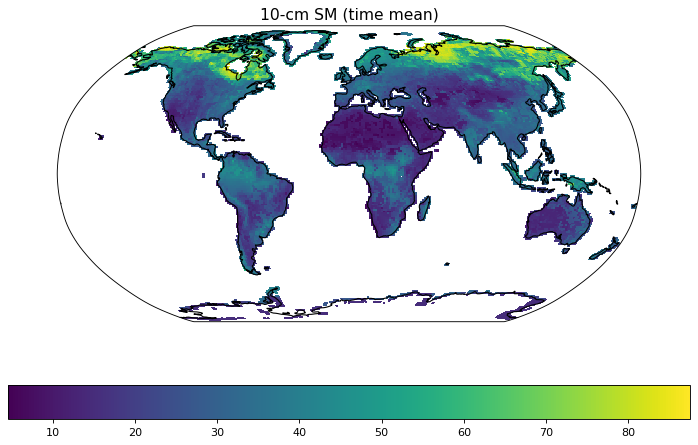

In [40]:
# Does SM look okay? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(clmDS_noDSL.SOILWATER_10CM.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,
                             SMavg_cyclic,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot,orientation='horizontal')
ax.set_title('10-cm SM (time mean)', fontsize=14)



Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

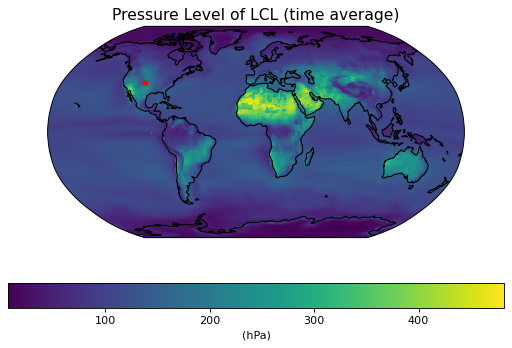

In [34]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,
                             transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)


In [34]:
# Make one big xr.Dataset containing all the information we need  
dFull_noDSL = camDS_noDSL
dFull_noDSL['soilM_10'] = (('time','lat','lon'), clmDS_noDSL.SOILWATER_10CM.values)
dFull_noDSL['Plcl'] = (('time','lat','lon'), Plcl)


**Now get CI**

In [35]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling = cm.metrics.CouplingIndex()
terraLeg_coupling = terraLeg_coupling.compute(dFull_noDSL, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terraLeg_coupling.to_netcdf('/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CLM5-noDSL.nc')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [36]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling = cm.metrics.CouplingIndex()
atmoLeg_coupling = atmoLeg_coupling.compute(dFull_noDSL, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file 
atmoLeg_coupling.to_netcdf('/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CLM5-noDSL.nc')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


**Compare to other cases**

In [37]:
AtmoLeg_JJA_clm5_noDSL   = np.squeeze(np.asarray(atmoLeg_coupling.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_noDSL  = np.squeeze(np.asarray(terraLeg_coupling.soilM_10_SHFLX_CI[1,:,:]))


### DSL+PHS changes undone

In [38]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS.001.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS.001.cam.h1.1979-83_CIvars.nc'

camDS_noDSLPHS         = xr.open_dataset(fileCAM, decode_times=True)
camDS_noDSLPHS['time'] = camDS_noDSLPHS.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_noDSLPHS         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_noDSLPHS['time'] = clmDS_noDSLPHS.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')



<ipython-input-38-adebb22db279>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_noDSLPHS['time'] = camDS_noDSLPHS.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-38-adebb22db279>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_noDSLPHS['time'] = clmDS_noDSLPHS.indexes['time'].to_datetimeindex()


In [39]:
## Compute LCL pressure 
nT = len(camDS_noDSLPHS['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_noDSLPHS['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_noDSLPHS['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_noDSLPHS['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_noDSLPHS['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 


Number of times:  1826
Done with  0.0  % of days
Done with  10.021905805038335  % of days
Done with  20.04381161007667  % of days
Done with  30.065717415115007  % of days
Done with  40.08762322015334  % of days
Done with  50.10952902519168  % of days
Done with  60.13143483023001  % of days
Done with  70.15334063526835  % of days
Done with  80.17524644030668  % of days
Done with  90.19715224534501  % of days
Finished computing LCL-pressure level successfully


<ipython-input-56-f0aed8115ae0>:8: RuntimeWarning: Mean of empty slice
  SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(clmDS_noDSLPHS.SOILWATER_10CM.values,0)), lon)


Text(0.5, 1.0, '10-cm SM (time mean)')

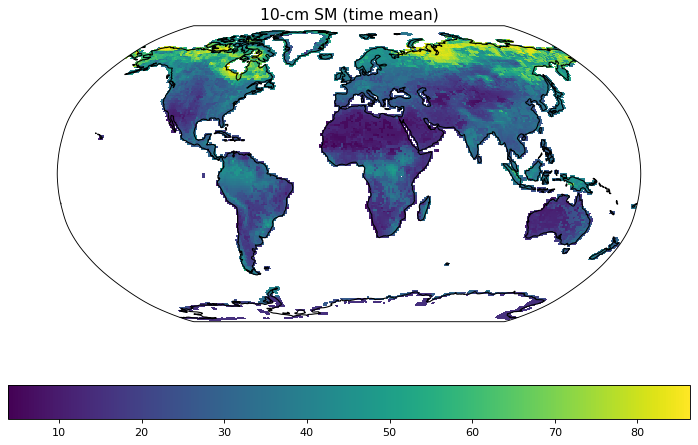

In [56]:
# Does SM look okay? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(clmDS_noDSLPHS.SOILWATER_10CM.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,
                             SMavg_cyclic,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot,orientation='horizontal')
ax.set_title('10-cm SM (time mean)', fontsize=14)



Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

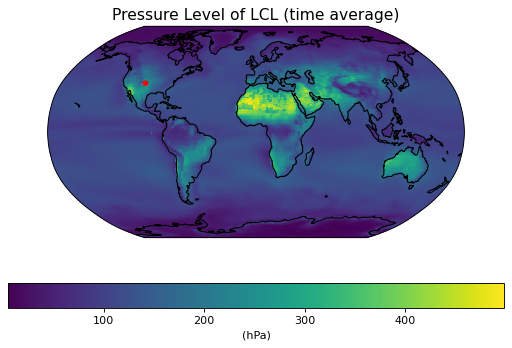

In [57]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,
                             transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)


In [40]:
# Make one big xr.Dataset containing all the information we need  
dFull_noDSLPHS = camDS_noDSLPHS
dFull_noDSLPHS['soilM_10'] = (('time','lat','lon'), clmDS_noDSLPHS.SOILWATER_10CM.values)
dFull_noDSLPHS['Plcl'] = (('time','lat','lon'), Plcl)



**Now get CI**

In [41]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_noDSLPHS = cm.metrics.CouplingIndex()
terraLeg_coupling_noDSLPHS = terraLeg_coupling_noDSLPHS.compute(dFull_noDSLPHS, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_noDSLPHS = cm.metrics.CouplingIndex()
atmoLeg_coupling_noDSLPHS = atmoLeg_coupling_noDSLPHS.compute(dFull_noDSLPHS, xname='SHFLX',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

**Compare to other cases**

In [42]:
AtmoLeg_JJA_clm5_noDSLPHS   = np.squeeze(np.asarray(atmoLeg_coupling_noDSLPHS.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_noDSLPHS  = np.squeeze(np.asarray(terraLeg_coupling_noDSLPHS.soilM_10_SHFLX_CI[1,:,:]))


### DSH, PHS, and FPI changes undone

In [43]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI.001.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI.001.cam.h1.1979-83_CIvars.nc'

camDS_noDSLPHSFPI         = xr.open_dataset(fileCAM, decode_times=True)
camDS_noDSLPHSFPI['time'] = camDS_noDSLPHSFPI.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_noDSLPHSFPI         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_noDSLPHSFPI['time'] = clmDS_noDSLPHSFPI.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')


<ipython-input-43-caf4e92c03ba>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_noDSLPHSFPI['time'] = camDS_noDSLPHSFPI.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-43-caf4e92c03ba>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_noDSLPHSFPI['time'] = clmDS_noDSLPHSFPI.indexes['time'].to_datetimeindex()


In [44]:
## Compute LCL pressure 
nT = len(camDS_noDSLPHSFPI['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_noDSLPHSFPI['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_noDSLPHSFPI['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_noDSLPHSFPI['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_noDSLPHSFPI['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 


Number of times:  1826
Done with  0.0  % of days
Done with  10.021905805038335  % of days
Done with  20.04381161007667  % of days
Done with  30.065717415115007  % of days
Done with  40.08762322015334  % of days
Done with  50.10952902519168  % of days
Done with  60.13143483023001  % of days
Done with  70.15334063526835  % of days
Done with  80.17524644030668  % of days
Done with  90.19715224534501  % of days
Finished computing LCL-pressure level successfully


In [45]:
# Make one big xr.Dataset containing all the information we need  
dFull_noDSLPHSFPI = camDS_noDSLPHSFPI
dFull_noDSLPHSFPI['soilM_10'] = (('time','lat','lon'), clmDS_noDSLPHSFPI.SOILWATER_10CM.values)
dFull_noDSLPHSFPI['Plcl'] = (('time','lat','lon'), Plcl)


**Now get CI**

In [46]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_noDSLPHSFPI = cm.metrics.CouplingIndex()
terraLeg_coupling_noDSLPHSFPI = terraLeg_coupling_noDSLPHSFPI.compute(dFull_noDSLPHSFPI, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_noDSLPHSFPI = cm.metrics.CouplingIndex()
atmoLeg_coupling_noDSLPHSFPI = atmoLeg_coupling_noDSLPHSFPI.compute(dFull_noDSLPHSFPI, xname='SHFLX',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [47]:
AtmoLeg_JJA_clm5_noDSLPHSFPI   = np.squeeze(np.asarray(atmoLeg_coupling_noDSLPHSFPI.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_noDSLPHSFPI  = np.squeeze(np.asarray(terraLeg_coupling_noDSLPHSFPI.soilM_10_SHFLX_CI[1,:,:]))


### What about those runs with zetamax and undercanopy stability altered?

In [55]:
terra_zetaMaxFile = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CESM2-zetamax2.nc'
atmo_zetaMaxFile = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CESM2-zetamax2.nc'

terra_undercanopyFile = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CESM2-undercanopy.nc'
atmo_undercanopyFile  = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CESM2-undercanopy.nc'

terraCI_zetamax = xr.open_dataset(terra_zetaMaxFile)
atmoCI_zetamax  = xr.open_dataset(atmo_zetaMaxFile)

terraCI_undercanopy = xr.open_dataset(terra_undercanopyFile)
atmoCI_undercanopy  = xr.open_dataset(atmo_undercanopyFile)


In [56]:
AtmoLeg_JJA_clm5_zetamax   = np.squeeze(np.asarray(atmoCI_zetamax.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_zetamax  = np.squeeze(np.asarray(terraCI_zetamax.soilM_10_SHFLX_CI[1,:,:]))

AtmoLeg_JJA_clm5_undercanopy  = np.squeeze(np.asarray(atmoCI_undercanopy.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_undercanopy = np.squeeze(np.asarray(terraCI_undercanopy.soilM_10_SHFLX_CI[1,:,:]))


<ipython-input-99-316fe3c57e45>:3: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
<ipython-input-99-316fe3c57e45>:4: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_JJA_cesm1*lndMask_notCyclic,axis=1)
<ipython-input-99-316fe3c57e45>:5: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)
<ipython-input-99-316fe3c57e45>:6: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CAM5  = np.nanmean(AtmoLeg_JJA_cam5*lndMask_notCyclic, axis=1)
<ipython-input-99-316fe3c57e45>:7: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM5_noDSL = np.nanmean(AtmoLeg_JJA_clm5_noDSL*lndMask_notCyclic,axis=1)
<ipython-input-99-316fe3c57e45>:8: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM5_noDSLPHS = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHS*lndMask_notCyclic,axis=1)
<ipython-input-99-316fe3c57e45>:9: RuntimeWarning: Mean of emp

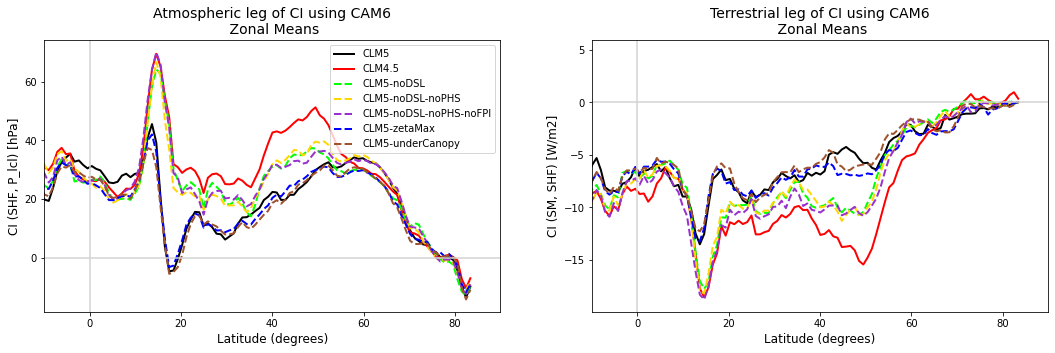

In [99]:
## Plot CI -- both legs 

lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_JJA_cesm1*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CAM5  = np.nanmean(AtmoLeg_JJA_cam5*lndMask_notCyclic, axis=1)
lonMean_atmoLeg_CLM5_noDSL = np.nanmean(AtmoLeg_JJA_clm5_noDSL*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSLPHS = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHS*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSLPHSFPI = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHSFPI*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_zetamax = np.nanmean(AtmoLeg_JJA_clm5_zetamax*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_undercanopy = np.nanmean(AtmoLeg_JJA_clm5_undercanopy*lndMask_notCyclic,axis=1)

lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_JJA_cesm2, axis=1)
lonMean_terraLeg_CESM1 = np.nanmean(TerraLeg_JJA_cesm1, axis=1)
lonMean_terraLeg_CLM45 = np.nanmean(TerraLeg_JJA_clm45, axis=1)
lonMean_terraLeg_CAM5  = np.nanmean(TerraLeg_JJA_cam5,  axis=1)
lonMean_terraLeg_CLM5_noDSL = np.nanmean(TerraLeg_JJA_clm5_noDSL*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_noDSLPHS = np.nanmean(TerraLeg_JJA_clm5_noDSLPHS*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_noDSLPHSFPI = np.nanmean(TerraLeg_JJA_clm5_noDSLPHSFPI*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_zetamax = np.nanmean(TerraLeg_JJA_clm5_zetamax*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_undercanopy = np.nanmean(TerraLeg_JJA_clm5_undercanopy*lndMask_notCyclic,axis=1)



# -- Atmospheric leg plot --- 
# Now plot that 
fig, axs = plt.subplots(1,2, figsize=(18, 5))
axs = axs.ravel()

axs[0].plot(lat,lonMean_atmoLeg_CESM2,'k',linewidth=2,label='CLM5')
axs[0].plot(lat,lonMean_atmoLeg_CLM45,'red',linewidth=2,label='CLM4.5')
axs[0].plot(lat,lonMean_atmoLeg_CLM5_noDSL,'lime',linewidth=2,label='CLM5-noDSL',linestyle='--')
axs[0].plot(lat,lonMean_atmoLeg_CLM5_noDSLPHS,'gold',linewidth=2,label='CLM5-noDSL-noPHS',linestyle='--')
axs[0].plot(lat,lonMean_atmoLeg_CLM5_noDSLPHSFPI,'darkorchid',linewidth=2,label='CLM5-noDSL-noPHS-noFPI',linestyle='--')
axs[0].plot(lat,lonMean_atmoLeg_CLM5_zetamax,'blue',linewidth=2,label='CLM5-zetaMax',linestyle='--')
axs[0].plot(lat,lonMean_atmoLeg_CLM5_undercanopy,'sienna',linewidth=2,label='CLM5-underCanopy',linestyle='--')



axs[0].legend()
axs[0].set_xlabel('Latitude (degrees)',fontsize=12)
axs[0].set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=12)
axs[0].set_title('Atmospheric leg of CI using CAM6\n Zonal Means',fontsize=14)
axs[0].set_xlim([-10, 90])
axs[0].axhline(0,color='lightgrey')
axs[0].axvline(0,color='lightgrey')

# -- Terrestrial leg --- 

axs[1].plot(lat,lonMean_terraLeg_CESM2,'k',linewidth=2)
axs[1].plot(lat,lonMean_terraLeg_CLM45,'red',linewidth=2)
axs[1].plot(lat,lonMean_terraLeg_CLM5_noDSL,'lime',linewidth=2,linestyle='--')
axs[1].plot(lat,lonMean_terraLeg_CLM5_noDSLPHS,'gold',linewidth=2,linestyle='--')
axs[1].plot(lat,lonMean_terraLeg_CLM5_noDSLPHSFPI,'darkorchid',linewidth=2,linestyle='--')
axs[1].plot(lat,lonMean_terraLeg_CLM5_zetamax,'blue',linewidth=2,linestyle='--')
axs[1].plot(lat,lonMean_terraLeg_CLM5_undercanopy,'sienna',linewidth=2,linestyle='--')

#axs[1].legend(['CLM5+CAM6','CLM4+CAM5','CLM4.5+CAM6','CLM5+CAM5','CLM5-noDSL+CAM6','CLM5-noDSL-noPHS','CLM5-noDSL-noPHS-noFPI'])
#ax1.legend(['CESM2','CESM1','CLM4.5+CAM6'],fontsize=14)
axs[1].set_xlabel('Latitude (degrees)',fontsize=12)
axs[1].set_ylabel('CI (SM, SHF) [W/m2]',fontsize=12)
axs[1].set_title('Terrestrial leg of CI using CAM6\n Zonal Means',fontsize=14)
axs[1].set_xlim([-10, 90])
axs[1].axhline(0,color='lightgrey')
axs[1].axvline(0,color='lightgrey')


### Same as above, but also revert a few soil water handling changes 
Use the 10 levels of CLM4.5, not the 20 levels of CLM5 in the soil. <br>
Also change the rooting profile method (rooting_profile_method_water). 

In [48]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc.001.cam.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc.001.cam.h1.1979-83_CIvars.nc'

camDS_noDSLPHSFPIroots         = xr.open_dataset(fileCAM, decode_times=True)
camDS_noDSLPHSFPIroots['time'] = camDS_noDSLPHSFPIroots.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_noDSLPHSFPIroots         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_noDSLPHSFPIroots['time'] = clmDS_noDSLPHSFPIroots.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')


<ipython-input-48-64745a0f92cf>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_noDSLPHSFPIroots['time'] = camDS_noDSLPHSFPIroots.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-48-64745a0f92cf>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_noDSLPHSFPIroots['time'] = clmDS_noDSLPHSFPIroots.indexes['time'].to_datetimeindex()


In [49]:
## Compute LCL pressure 
nT = len(camDS_noDSLPHSFPIroots['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_noDSLPHSFPIroots['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_noDSLPHSFPIroots['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_noDSLPHSFPIroots['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_noDSLPHSFPIroots['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 



Number of times:  1826
Done with  0.0  % of days
Done with  10.021905805038335  % of days
Done with  20.04381161007667  % of days
Done with  30.065717415115007  % of days
Done with  40.08762322015334  % of days
Done with  50.10952902519168  % of days
Done with  60.13143483023001  % of days
Done with  70.15334063526835  % of days
Done with  80.17524644030668  % of days
Done with  90.19715224534501  % of days
Finished computing LCL-pressure level successfully


In [50]:
# Make one big xr.Dataset containing all the information we need  
dFull_noDSLPHSFPIroots = camDS_noDSLPHSFPIroots
dFull_noDSLPHSFPIroots['soilM_10'] = (('time','lat','lon'), clmDS_noDSLPHSFPIroots.SOILWATER_10CM.values)
dFull_noDSLPHSFPIroots['Plcl'] = (('time','lat','lon'), Plcl)


In [51]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_noDSLPHSFPIroots = cm.metrics.CouplingIndex()
terraLeg_coupling_noDSLPHSFPIroots = terraLeg_coupling_noDSLPHSFPIroots.compute(dFull_noDSLPHSFPIroots, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_noDSLPHSFPIroots = cm.metrics.CouplingIndex()
atmoLeg_coupling_noDSLPHSFPIroots = atmoLeg_coupling_noDSLPHSFPIroots.compute(dFull_noDSLPHSFPIroots, xname='SHFLX',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [52]:
AtmoLeg_JJA_clm5_noDSLPHSFPIroots   = np.squeeze(np.asarray(atmoLeg_coupling_noDSLPHSFPIroots.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_noDSLPHSFPIroots  = np.squeeze(np.asarray(terraLeg_coupling_noDSLPHSFPIroots.soilM_10_SHFLX_CI[1,:,:]))


### Also remove soilwater_movement_method changes

In [53]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement.001.cam.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement.001.cam.h1.1979-83_CIvars.nc'

camDS_noDSLPHSFPIrootsWaterMov         = xr.open_dataset(fileCAM, decode_times=True)
camDS_noDSLPHSFPIrootsWaterMov['time'] = camDS_noDSLPHSFPIrootsWaterMov.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_noDSLPHSFPIrootsWaterMov         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_noDSLPHSFPIrootsWaterMov['time'] = clmDS_noDSLPHSFPIrootsWaterMov.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')



<ipython-input-53-d3182475cfd7>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_noDSLPHSFPIrootsWaterMov['time'] = camDS_noDSLPHSFPIrootsWaterMov.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-53-d3182475cfd7>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_noDSLPHSFPIrootsWaterMov['time'] = clmDS_noDSLPHSFPIrootsWaterMov.indexes['time'].to_datetimeindex()


In [54]:
## Compute LCL pressure 
nT = len(camDS_noDSLPHSFPIrootsWaterMov['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_noDSLPHSFPIrootsWaterMov['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_noDSLPHSFPIrootsWaterMov['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_noDSLPHSFPIrootsWaterMov['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_noDSLPHSFPIrootsWaterMov['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 


Number of times:  1826
Done with  0.0  % of days
Done with  10.021905805038335  % of days
Done with  20.04381161007667  % of days
Done with  30.065717415115007  % of days
Done with  40.08762322015334  % of days
Done with  50.10952902519168  % of days
Done with  60.13143483023001  % of days
Done with  70.15334063526835  % of days
Done with  80.17524644030668  % of days
Done with  90.19715224534501  % of days
Finished computing LCL-pressure level successfully


In [55]:
# Make one big xr.Dataset containing all the information we need  
dFull_noDSLPHSFPIrootsWaterMov = camDS_noDSLPHSFPIrootsWaterMov
dFull_noDSLPHSFPIrootsWaterMov['soilM_10'] = (('time','lat','lon'), clmDS_noDSLPHSFPIrootsWaterMov.SOILWATER_10CM.values)
dFull_noDSLPHSFPIrootsWaterMov['Plcl'] = (('time','lat','lon'), Plcl)


In [56]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_noDSLPHSFPIrootsWaterMov = cm.metrics.CouplingIndex()
terraLeg_coupling_noDSLPHSFPIrootsWaterMov = terraLeg_coupling_noDSLPHSFPIrootsWaterMov.compute(dFull_noDSLPHSFPIrootsWaterMov, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_noDSLPHSFPIrootsWaterMov = cm.metrics.CouplingIndex()
atmoLeg_coupling_noDSLPHSFPIrootsWaterMov = atmoLeg_coupling_noDSLPHSFPIrootsWaterMov.compute(dFull_noDSLPHSFPIrootsWaterMov, xname='SHFLX',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [57]:
AtmoLeg_JJA_clm5_noDSLPHSFPIrootsWaterMov   = np.squeeze(np.asarray(atmoLeg_coupling_noDSLPHSFPIrootsWaterMov.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_noDSLPHSFPIrootsWaterMov  = np.squeeze(np.asarray(terraLeg_coupling_noDSLPHSFPIrootsWaterMov.soilM_10_SHFLX_CI[1,:,:]))


### Also revert the actual interception_fraction value and maximum_leaf_wetted_fraction 

In [58]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept.001.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept.001.cam.h1.1979-83_CIvars.nc'

camDS_noDSLPHSFPIrootsWaterMovLeafintercept         = xr.open_dataset(fileCAM, decode_times=True)
camDS_noDSLPHSFPIrootsWaterMovLeafintercept['time'] = camDS_noDSLPHSFPIrootsWaterMovLeafintercept.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_noDSLPHSFPIrootsWaterMovLeafintercept         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_noDSLPHSFPIrootsWaterMovLeafintercept['time'] = clmDS_noDSLPHSFPIrootsWaterMovLeafintercept.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')


<ipython-input-58-d2ed2c24954b>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_noDSLPHSFPIrootsWaterMovLeafintercept['time'] = camDS_noDSLPHSFPIrootsWaterMovLeafintercept.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-58-d2ed2c24954b>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_noDSLPHSFPIrootsWaterMovLeafintercept['time'] = clmDS_noDSLPHSFPIrootsWaterMovLeafintercept.indexes['time'].to_datetimeindex()


In [59]:
## Compute LCL pressure 
nT = len(camDS_noDSLPHSFPIrootsWaterMovLeafintercept['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_noDSLPHSFPIrootsWaterMovLeafintercept['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_noDSLPHSFPIrootsWaterMovLeafintercept['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_noDSLPHSFPIrootsWaterMovLeafintercept['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_noDSLPHSFPIrootsWaterMovLeafintercept['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 


Number of times:  1826
Done with  0.0  % of days
Done with  10.021905805038335  % of days
Done with  20.04381161007667  % of days
Done with  30.065717415115007  % of days
Done with  40.08762322015334  % of days
Done with  50.10952902519168  % of days
Done with  60.13143483023001  % of days
Done with  70.15334063526835  % of days
Done with  80.17524644030668  % of days
Done with  90.19715224534501  % of days
Finished computing LCL-pressure level successfully


In [60]:
# Make one big xr.Dataset containing all the information we need  
dFull_noDSLPHSFPIrootsWaterMovLeafintercept = camDS_noDSLPHSFPIrootsWaterMovLeafintercept
dFull_noDSLPHSFPIrootsWaterMovLeafintercept['soilM_10'] = (('time','lat','lon'), clmDS_noDSLPHSFPIrootsWaterMovLeafintercept.SOILWATER_10CM.values)
dFull_noDSLPHSFPIrootsWaterMovLeafintercept['Plcl'] = (('time','lat','lon'), Plcl)


In [61]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept = cm.metrics.CouplingIndex()
terraLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept = terraLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept.compute(dFull_noDSLPHSFPIrootsWaterMovLeafintercept, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept = cm.metrics.CouplingIndex()
atmoLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept = atmoLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept.compute(dFull_noDSLPHSFPIrootsWaterMovLeafintercept, xname='SHFLX',yname='Plcl',averaging='season')



/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [62]:
AtmoLeg_JJA_clm5_noDSLPHSFPIrootsWaterMovLeafintercept   = np.squeeze(np.asarray(atmoLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_noDSLPHSFPIrootsWaterMovLeafintercept  = np.squeeze(np.asarray(terraLeg_coupling_noDSLPHSFPIrootsWaterMovLeafintercept.soilM_10_SHFLX_CI[1,:,:]))


### Any chance it *is* the snow variables?

In [72]:
fileCLM = dataDir+'f.e21.FHIST_BGC.f09_f09.cesm2_cam6_clm5_snowdensity.002.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST_BGC.f09_f09.cesm2_cam6_clm5_snowdensity.002.cam.h1.1979-83_CIvars.nc'

camDS_snowVars         = xr.open_dataset(fileCAM, decode_times=True)
camDS_snowVars['time'] = camDS_snowVars.indexes['time'].to_datetimeindex()
# Limit to same time period as CLM 
camDS_snowVars = camDS_snowVars.isel(time=np.arange(0,1830))
print('Finished reading in CAM file')

clmDS_snowVars         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_snowVars['time'] = clmDS_snowVars.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')



<ipython-input-72-fb7220cd280d>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_snowVars['time'] = camDS_snowVars.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-72-fb7220cd280d>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_snowVars['time'] = clmDS_snowVars.indexes['time'].to_datetimeindex()


In [73]:
## Compute LCL pressure 
nT = len(camDS_snowVars['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_snowVars['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_snowVars['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_snowVars['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_snowVars['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 


Number of times:  1830
Done with  0.0  % of days
Done with  10.0  % of days
Done with  20.0  % of days
Done with  30.0  % of days
Done with  40.0  % of days
Done with  50.0  % of days
Done with  60.0  % of days
Done with  70.0  % of days
Done with  80.0  % of days
Done with  90.0  % of days
Finished computing LCL-pressure level successfully


In [74]:
# Make one big xr.Dataset containing all the information we need  
dFull_snowVars = camDS_snowVars
dFull_snowVars['soilM_10'] = (('time','lat','lon'), clmDS_snowVars.SOILWATER_10CM.values)
dFull_snowVars['Plcl'] = (('time','lat','lon'), Plcl)


In [75]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_snowVars = cm.metrics.CouplingIndex()
terraLeg_coupling_snowVars = terraLeg_coupling_snowVars.compute(dFull_snowVars, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_snowVars = cm.metrics.CouplingIndex()
atmoLeg_coupling_snowVars = atmoLeg_coupling_snowVars.compute(dFull_snowVars, xname='SHFLX',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [76]:
AtmoLeg_JJA_clm5_snowVars   = np.squeeze(np.asarray(atmoLeg_coupling_snowVars.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_snowVars  = np.squeeze(np.asarray(terraLeg_coupling_snowVars.soilM_10_SHFLX_CI[1,:,:]))



### What if it's some of the variables in paramfile?

In [63]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept-newParamFile.001.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept-newParamFile.001.cam.h1.1979-83_CIvars.nc'

camDS_AllAndParams         = xr.open_dataset(fileCAM, decode_times=True)
camDS_AllAndParams['time'] = camDS_AllAndParams.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_AllAndParams         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_AllAndParams['time'] = clmDS_AllAndParams.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')


<ipython-input-63-05407f995af3>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_AllAndParams['time'] = camDS_AllAndParams.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-63-05407f995af3>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_AllAndParams['time'] = clmDS_AllAndParams.indexes['time'].to_datetimeindex()


In [64]:
## Compute LCL pressure 
nT = len(camDS_AllAndParams['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_AllAndParams['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_AllAndParams['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_AllAndParams['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_AllAndParams['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 


Number of times:  1826
Done with  0.0  % of days
Done with  10.021905805038335  % of days
Done with  20.04381161007667  % of days
Done with  30.065717415115007  % of days
Done with  40.08762322015334  % of days
Done with  50.10952902519168  % of days
Done with  60.13143483023001  % of days
Done with  70.15334063526835  % of days
Done with  80.17524644030668  % of days
Done with  90.19715224534501  % of days
Finished computing LCL-pressure level successfully


In [65]:
# Make one big xr.Dataset containing all the information we need  
dFull_AllAndParams = camDS_AllAndParams
dFull_AllAndParams['soilM_10'] = (('time','lat','lon'), clmDS_AllAndParams.SOILWATER_10CM.values)
dFull_AllAndParams['Plcl'] = (('time','lat','lon'), Plcl)


In [66]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_AllAndParams = cm.metrics.CouplingIndex()
terraLeg_coupling_AllAndParams = terraLeg_coupling_AllAndParams.compute(dFull_AllAndParams, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_AllAndParams = cm.metrics.CouplingIndex()
atmoLeg_coupling_AllAndParams = atmoLeg_coupling_AllAndParams.compute(dFull_AllAndParams, xname='SHFLX',yname='Plcl',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [67]:
AtmoLeg_JJA_clm5_AllAndParams   = np.squeeze(np.asarray(atmoLeg_coupling_AllAndParams.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_AllAndParams  = np.squeeze(np.asarray(terraLeg_coupling_AllAndParams.soilM_10_SHFLX_CI[1,:,:]))


### Try using the entirety of CLM4.5's parameter file??

In [68]:
fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept-clm45paramFile.001.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept-clm45paramFile.001.cam.h1.1979-83_CIvars.nc'

camDS_AllAndAllParams         = xr.open_dataset(fileCAM, decode_times=True)
camDS_AllAndAllParams['time'] = camDS_AllAndAllParams.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_AllAndAllParams         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_AllAndAllParams['time'] = clmDS_AllAndAllParams.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')



<ipython-input-68-1627e022a174>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_AllAndAllParams['time'] = camDS_AllAndAllParams.indexes['time'].to_datetimeindex()


Finished reading in CAM file
Finished reading in CLM file


<ipython-input-68-1627e022a174>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_AllAndAllParams['time'] = clmDS_AllAndAllParams.indexes['time'].to_datetimeindex()


In [69]:
## Compute LCL pressure 
nT = len(camDS_AllAndAllParams['time'].values)
print('Number of times: ', nT)

# Convert temperature to ˚C 
T_degC = camDS_AllAndAllParams['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_AllAndAllParams['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_AllAndAllParams['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_AllAndAllParams['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

print('Finished computing LCL-pressure level successfully') 



Number of times:  1826
Done with  0.0  % of days
Done with  10.021905805038335  % of days
Done with  20.04381161007667  % of days
Done with  30.065717415115007  % of days
Done with  40.08762322015334  % of days
Done with  50.10952902519168  % of days
Done with  60.13143483023001  % of days
Done with  70.15334063526835  % of days
Done with  80.17524644030668  % of days
Done with  90.19715224534501  % of days
Finished computing LCL-pressure level successfully


In [70]:
# Make one big xr.Dataset containing all the information we need  
dFull_AllAndAllParams = camDS_AllAndAllParams
dFull_AllAndAllParams['soilM_10'] = (('time','lat','lon'), clmDS_AllAndAllParams.SOILWATER_10CM.values)
dFull_AllAndAllParams['Plcl'] = (('time','lat','lon'), Plcl)

In [71]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling_AllAndAllParams = cm.metrics.CouplingIndex()
terraLeg_coupling_AllAndAllParams = terraLeg_coupling_AllAndAllParams.compute(dFull_AllAndAllParams, xname='soilM_10',yname='SHFLX',averaging='season')

# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling_AllAndAllParams = cm.metrics.CouplingIndex()
atmoLeg_coupling_AllAndAllParams = atmoLeg_coupling_AllAndAllParams.compute(dFull_AllAndAllParams, xname='SHFLX',yname='Plcl',averaging='season')



/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s",

In [72]:
AtmoLeg_JJA_clm5_AllAndAllParams   = np.squeeze(np.asarray(atmoLeg_coupling_AllAndAllParams.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm5_AllAndAllParams  = np.squeeze(np.asarray(terraLeg_coupling_AllAndAllParams.soilM_10_SHFLX_CI[1,:,:]))



### Final figure build up sequence:

In [82]:
# Use a simple moving average over latitude to smooth out zonal means
#  Method here: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
#  Left centered moving average (i.e., latitude mean assigned to lowest value is mean of that value and next two)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


In [74]:
# Get zonal mean values 
lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSL = np.nanmean(AtmoLeg_JJA_clm5_noDSL*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSLPHS = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHS*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSLPHSFPI = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHSFPI*lndMask_notCyclic,axis=1)
# lonMean_atmoLeg_CLM5_zetamax = np.nanmean(AtmoLeg_JJA_clm5_zetamax*lndMask_notCyclic,axis=1)
# lonMean_atmoLeg_CLM5_undercanopy = np.nanmean(AtmoLeg_JJA_clm5_undercanopy*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSLPHSFPIroots = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHSFPIroots*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMov = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHSFPIrootsWaterMov*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHSFPIrootsWaterMovLeafintercept*lndMask_notCyclic,axis=1)
# lonMean_atmoLeg_CLM5_snowVars = np.nanmean(AtmoLeg_JJA_clm5_snowVars*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_AllAndParams = np.nanmean(AtmoLeg_JJA_clm5_AllAndParams*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM5_AllAndAllParams = np.nanmean(AtmoLeg_JJA_clm5_AllAndAllParams*lndMask_notCyclic,axis=1)


lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_JJA_cesm2, axis=1)
lonMean_terraLeg_CLM45 = np.nanmean(TerraLeg_JJA_clm45, axis=1)
lonMean_terraLeg_CLM5_noDSL = np.nanmean(TerraLeg_JJA_clm5_noDSL*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_noDSLPHS = np.nanmean(TerraLeg_JJA_clm5_noDSLPHS*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_noDSLPHSFPI = np.nanmean(TerraLeg_JJA_clm5_noDSLPHSFPI*lndMask_notCyclic,axis=1)
# lonMean_terraLeg_CLM5_zetamax = np.nanmean(TerraLeg_JJA_clm5_zetamax*lndMask_notCyclic,axis=1)
# lonMean_terraLeg_CLM5_undercanopy = np.nanmean(TerraLeg_JJA_clm5_undercanopy*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_noDSLPHSFPIroots = np.nanmean(TerraLeg_JJA_clm5_noDSLPHSFPIroots*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMov = np.nanmean(TerraLeg_JJA_clm5_noDSLPHSFPIrootsWaterMov*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept = np.nanmean(TerraLeg_JJA_clm5_noDSLPHSFPIrootsWaterMovLeafintercept*lndMask_notCyclic,axis=1)
# lonMean_terraLeg_CLM5_snowVars = np.nanmean(TerraLeg_JJA_clm5_snowVars*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_AllAndParams = np.nanmean(TerraLeg_JJA_clm5_AllAndParams*lndMask_notCyclic,axis=1)
lonMean_terraLeg_CLM5_AllAndAllParams = np.nanmean(TerraLeg_JJA_clm5_AllAndAllParams*lndMask_notCyclic,axis=1)



<ipython-input-74-8788382eb609>:2: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
<ipython-input-74-8788382eb609>:3: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)
<ipython-input-74-8788382eb609>:4: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM5_noDSL = np.nanmean(AtmoLeg_JJA_clm5_noDSL*lndMask_notCyclic,axis=1)
<ipython-input-74-8788382eb609>:5: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM5_noDSLPHS = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHS*lndMask_notCyclic,axis=1)
<ipython-input-74-8788382eb609>:6: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM5_noDSLPHSFPI = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHSFPI*lndMask_notCyclic,axis=1)
<ipython-input-74-8788382eb609>:9: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM5_noDSLPHSFPIroots = np.nanmean(AtmoLeg_JJA_clm5_noDSLPHSFPIroots*lndMask_notCyclic,axis=1)
<ipython

In [75]:
## Apply smoothing 

w = 3    # Number of latitudes to compute window over (~2.5-3˚)
print('Latitude diff aroud: ', (lat[80] - lat[80-w]), '˚')

lonMean_atmoLeg_CESM2            = moving_average(lonMean_atmoLeg_CESM2, w)
lonMean_atmoLeg_CLM45            = moving_average(lonMean_atmoLeg_CLM45, w)
lonMean_atmoLeg_CLM5_noDSL       = moving_average(lonMean_atmoLeg_CLM5_noDSL, w)
lonMean_atmoLeg_CLM5_noDSLPHS    = moving_average(lonMean_atmoLeg_CLM5_noDSLPHS, w)
lonMean_atmoLeg_CLM5_noDSLPHSFPI = moving_average(lonMean_atmoLeg_CLM5_noDSLPHSFPI, w)
# lonMean_atmoLeg_CLM5_zetamax     = moving_average(lonMean_atmoLeg_CLM5_zetamax, w)
# lonMean_atmoLeg_CLM5_undercanopy = moving_average(lonMean_atmoLeg_CLM5_undercanopy, w)
lonMean_atmoLeg_CLM5_noDSLPHSFPIroots                      = moving_average(lonMean_atmoLeg_CLM5_noDSLPHSFPIroots, w)
lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMov              = moving_average(lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMov, w)
lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept = moving_average(lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept, w)
# lonMean_atmoLeg_CLM5_snowVars                              = moving_average(lonMean_atmoLeg_CLM5_snowVars, w)
lonMean_atmoLeg_CLM5_AllAndParams                          = moving_average(lonMean_atmoLeg_CLM5_AllAndParams, w)
lonMean_atmoLeg_CLM5_AllAndAllParams                       = moving_average(lonMean_atmoLeg_CLM5_AllAndAllParams, w)



lonMean_terraLeg_CESM2            = moving_average(lonMean_terraLeg_CESM2, w)
lonMean_terraLeg_CLM45            = moving_average(lonMean_terraLeg_CLM45, w)
lonMean_terraLeg_CLM5_noDSL       = moving_average(lonMean_terraLeg_CLM5_noDSL, w)
lonMean_terraLeg_CLM5_noDSLPHS    = moving_average(lonMean_terraLeg_CLM5_noDSLPHS, w)
lonMean_terraLeg_CLM5_noDSLPHSFPI = moving_average(lonMean_terraLeg_CLM5_noDSLPHSFPI, w)
# lonMean_terraLeg_CLM5_zetamax     = moving_average(lonMean_terraLeg_CLM5_zetamax, w)
# lonMean_terraLeg_CLM5_undercanopy = moving_average(lonMean_terraLeg_CLM5_undercanopy, w)
lonMean_terraLeg_CLM5_noDSLPHSFPIroots                      = moving_average(lonMean_terraLeg_CLM5_noDSLPHSFPIroots, w)
lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMov              = moving_average(lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMov, w)
lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept = moving_average(lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept, w)
# lonMean_terraLeg_CLM5_snowVars                              = moving_average(lonMean_terraLeg_CLM5_snowVars, w)
lonMean_terraLeg_CLM5_AllAndParams                          = moving_average(lonMean_terraLeg_CLM5_AllAndParams, w)
lonMean_terraLeg_CLM5_AllAndAllParams                       = moving_average(lonMean_terraLeg_CLM5_AllAndAllParams, w)

smoothLat = moving_average(lat,w)


Latitude diff aroud:  2.827225685119629 ˚


(-20.0, 4.0)

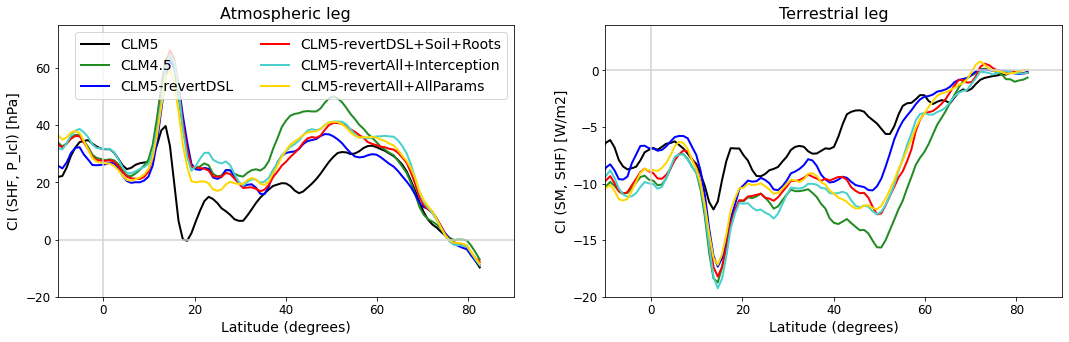

In [77]:
## Plot CI -- both legs 


# --- Plot atmospheric leg ---- 

# Now plot that 
fig, axs = plt.subplots(1,2, figsize=(18, 5))
axs = axs.ravel()

axs[0].plot(smoothLat,lonMean_atmoLeg_CESM2,'k',linewidth=2,label='CLM5')
axs[0].plot(smoothLat,lonMean_atmoLeg_CLM45,'forestgreen',linewidth=2,label='CLM4.5')
# axs[0].plot(smoothLat, lonMean_atmoLeg_CLM5_zetamax,'orange',linewidth=2,label='CLM5-RevertZetamax')
# axs[0].plot(smoothLat, lonMean_atmoLeg_CLM5_undercanopy,'red',linewidth=2,label='CLM5-RevertUndercanopy')
axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_noDSL,'blue',linewidth=2,label='CLM5-revertDSL',linestyle='-')
# axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_noDSLPHS,'goldenrod',linewidth=2,label='CLM5-revertDSL+PHS',linestyle='-')
# axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_noDSLPHSFPI,'darkviolet',linewidth=2,label='CLM5-revertDSL+PHS+FPI',linestyle='-')
# axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_noDSLPHSFPIroots,'darkorange',linewidth=2,label='CLM5-revertAll+SoilRootStruct',linestyle='-')
axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMov,'red',linewidth=2,label='CLM5-revertDSL+Soil+Roots',linestyle='-')
axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept,'mediumturquoise',linewidth=2,label='CLM5-revertAll+Interception',linestyle='-')
#axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_snowVars,'turquoise',linewidth=2,label='CLM5-revertSnowVars',linestyle='-')
# axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_AllAndParams,'magenta',linewidth=2,label='CLM5-revertAll+Params',linestyle='-')
axs[0].plot(smoothLat,lonMean_atmoLeg_CLM5_AllAndAllParams,'gold',linewidth=2,label='CLM5-revertAll+AllParams',linestyle='-')



axs[0].legend(fontsize=14,ncol=2)
axs[0].set_xlabel('Latitude (degrees)',fontsize=14)
axs[0].set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=14)
axs[0].set_title('Atmospheric leg',fontsize=16)
axs[0].set_xlim([-10, 90])
axs[0].axhline(0,color='lightgrey')
axs[0].axvline(0,color='lightgrey')

# --- Plot terrestrial leg ---- 
axs[1].plot(smoothLat,lonMean_terraLeg_CESM2,'k',linewidth=2)
axs[1].plot(smoothLat,lonMean_terraLeg_CLM45,'forestgreen',linewidth=2)
# axs[1].plot(smoothLat, lonMean_terraLeg_CLM5_zetamax,'orange',linewidth=2,label='CLM5-RevertZetamax')
# axs[1].plot(smoothLat, lonMean_terraLeg_CLM5_undercanopy,'red',linewidth=2,label='CLM5-RevertUndercanopy')
axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_noDSL,'blue',linewidth=2,label='CLM5-revertDSL',linestyle='-')
# axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_noDSLPHS,'goldenrod',linewidth=2,label='CLM5-revertDSL+PHS',linestyle='-')
# axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_noDSLPHSFPI,'darkviolet',linewidth=2,label='CLM5-revertDSL+PHS+FPI',linestyle='-')
# axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_noDSLPHSFPIroots,'darkorange',linewidth=2,label='CLM5-revertFullSet',linestyle='-')
axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMov,'red',linewidth=2,label='CLM5-revertAll+WaterMov',linestyle='-')
axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_noDSLPHSFPIrootsWaterMovLeafintercept,'mediumturquoise',linewidth=2,label='CLM5-revertAll+WaterMov',linestyle='-')
#axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_snowVars,'turquoise',linewidth=2,label='CLM5-revertSnowVars',linestyle='-')
# axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_AllAndParams,'magenta',linewidth=2,label='CLM5-revertAll+Params',linestyle='-')
axs[1].plot(smoothLat,lonMean_terraLeg_CLM5_AllAndAllParams,'gold',linewidth=2,label='CLM5-revertAll+Params',linestyle='-')




axs[1].set_xlabel('Latitude (degrees)',fontsize=14)
axs[1].set_ylabel('CI (SM, SHF) [W/m2]',fontsize=14)
axs[1].set_title('Terrestrial leg',fontsize=16)
axs[1].set_xlim([-10, 90])
axs[1].axhline(0,color='lightgrey')
axs[1].axvline(0,color='lightgrey')

axs[0].tick_params(axis='both',labelsize=12)
axs[1].tick_params(axis='both',labelsize=12)
axs[0].set_ylim([-20,75])
axs[1].set_ylim([-20,4])



### What else can it be???

In [123]:
clm5_file        = 'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept-clm45paramFile.001.clm2.h0.1979-83_snowVars.nc'
clm45_fileCecile = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h0.1979-83_snowVars.nc'
clm5_snowFile    = 'f.e21.FHIST_BGC.f09_f09.cesm2_cam6_clm5_snowdensity.002.clm2.h0.1979-83_snowVars.nc'

clm5_precipDS         = xr.open_dataset(dataDir+clm5_file,decode_times=True)
clm5_precipDS['time'] = clm5_precipDS.indexes['time'].to_datetimeindex()

clm45cecile_precipDS = xr.open_dataset(dataDir+clm45_fileCecile, decode_times=True)
clm45cecile_precipDS['time'] = clm45cecile_precipDS.indexes['time'].to_datetimeindex()

clm5snow_precipDS         = xr.open_dataset(dataDir+clm5_snowFile,decode_times=True)
clm5snow_precipDS['time'] = clm5snow_precipDS.indexes['time'].to_datetimeindex()


<ipython-input-123-05e860ea8620>:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm5_precipDS['time'] = clm5_precipDS.indexes['time'].to_datetimeindex()
<ipython-input-123-05e860ea8620>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm45cecile_precipDS['time'] = clm45cecile_precipDS.indexes['time'].to_datetimeindex()
<ipython-input-123-05e860ea8620>:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations

In [176]:
clm5_irrigFile  = 'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept-clm45paramFile.001.clm2.h0.1979-83_Qirrig.nc'
clm45_irrigFile = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h0.1979-83_Qirrig.nc'

clm5_icerunFile  = 'f.e21.FHIST.f09_f09_mg17.CESM2-NoDSL-NoPHS-NoFPI-NoSoilRootsEtc-SoilWaterMovement-leafIntercept-clm45paramFile.001.clm2.h0.1979-83_iceMeltVars.nc'
clm45_icerunFile = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h0.1979-83_iceMeltVars.nc'

clm5_irrigDS         = xr.open_dataset(dataDir+clm5_irrigFile,decode_times=True)
clm5_irrigDS['time'] = clm5_irrigDS.indexes['time'].to_datetimeindex()

clm45_irrigDS = xr.open_dataset(dataDir+clm45_irrigFile, decode_times=True)
clm45_irrigDS['time'] = clm45_irrigDS.indexes['time'].to_datetimeindex()

clm5_icerunDS         = xr.open_dataset(dataDir+clm5_icerunFile,decode_times=True)
clm5_icerunDS['time'] = clm5_icerunDS.indexes['time'].to_datetimeindex()

clm45_icerunDS = xr.open_dataset(dataDir+clm45_icerunFile, decode_times=True)
clm45_icerunDS['time'] = clm45_icerunDS.indexes['time'].to_datetimeindex()


<ipython-input-176-72cada36a9e3>:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm5_irrigDS['time'] = clm5_irrigDS.indexes['time'].to_datetimeindex()
<ipython-input-176-72cada36a9e3>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm45_irrigDS['time'] = clm45_irrigDS.indexes['time'].to_datetimeindex()
<ipython-input-176-72cada36a9e3>:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on

In [124]:
# Get seasonal indices 
dates_clm5file    = pd.DatetimeIndex(clm5_precipDS['time'].values)
dates_clm45cecile = pd.DatetimeIndex(clm45cecile_precipDS['time'].values)
dates_clm5snow    = pd.DatetimeIndex(clm5snow_precipDS['time'].values)

iMAM_clm5 = np.where( (dates_clm5file.month>=4) & (dates_clm5file.month<=6) )[0]
iMAM_clm45 = np.where( (dates_clm45cecile.month>=4) & (dates_clm45cecile.month<=6) )[0]
iMAM_clm5snow = np.where( (dates_clm5snow.month>=4) & (dates_clm5snow.month<=6) )[0]

iJJA_clm5 = np.where( (dates_clm5file.month>=7) & (dates_clm5file.month<=9) )[0]
iJJA_clm45 = np.where( (dates_clm45cecile.month>=7) & (dates_clm45cecile.month<=9) )[0]
iJJA_clm5snow = np.where( (dates_clm5snow.month>=7) & (dates_clm5snow.month<=9) )[0]



In [131]:
# Get zonal mean by season
lonMean_MAM_RAIN_clm5 = np.nanmean(np.nanmean(clm5_precipDS.RAIN.values[iMAM_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_MAM_RAIN_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.RAIN.values[iMAM_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_MAM_SNOW_clm5 = np.nanmean(np.nanmean(clm5_precipDS.SNOW.values[iMAM_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_MAM_SNOW_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.SNOW.values[iMAM_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)

lonMean_JJA_RAIN_clm5 = np.nanmean(np.nanmean(clm5_precipDS.RAIN.values[iJJA_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_RAIN_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.RAIN.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_RAIN_clm5snow = np.nanmean(np.nanmean(clm5snow_precipDS.RAIN.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_SNOW_clm5 = np.nanmean(np.nanmean(clm5_precipDS.SNOW.values[iJJA_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_SNOW_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.SNOW.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_SNOW_clm5snow = np.nanmean(np.nanmean(clm5snow_precipDS.SNOW.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)

lonMean_JJA_QSNOMELT_clm5 = np.nanmean(np.nanmean(clm5_precipDS.QSNOMELT.values[iJJA_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_QSNOMELT_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.QSNOMELT.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_QSNOMELT_clm5snow = np.nanmean(np.nanmean(clm5snow_precipDS.QSNOMELT.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)


# Apply ~3˚ smoothing
lonMean_MAM_RAIN_clm5 = moving_average(lonMean_MAM_RAIN_clm5, w)
lonMean_MAM_RAIN_clm45 = moving_average(lonMean_MAM_RAIN_clm45, w)
lonMean_MAM_SNOW_clm5 = moving_average(lonMean_MAM_SNOW_clm5, w)
lonMean_MAM_SNOW_clm45 = moving_average(lonMean_MAM_SNOW_clm45, w)

lonMean_JJA_RAIN_clm5 = moving_average(lonMean_JJA_RAIN_clm5, w)
lonMean_JJA_RAIN_clm45 = moving_average(lonMean_JJA_RAIN_clm45, w)
lonMean_JJA_RAIN_clm5snow = moving_average(lonMean_JJA_RAIN_clm5snow,w)
lonMean_JJA_SNOW_clm5 = moving_average(lonMean_JJA_SNOW_clm5, w)
lonMean_JJA_SNOW_clm45 = moving_average(lonMean_JJA_SNOW_clm45, w)
lonMean_JJA_SNOW_clm5snow = moving_average(lonMean_JJA_SNOW_clm5snow, w)

lonMean_JJA_QSNOMELT_clm5 = moving_average(lonMean_JJA_QSNOMELT_clm5, w)
lonMean_JJA_QSNOMELT_clm45 = moving_average(lonMean_JJA_QSNOMELT_clm45, w)
lonMean_JJA_QSNOMELT_clm5snow = moving_average(lonMean_JJA_QSNOMELT_clm5snow, w)


<ipython-input-131-912a5848adbc>:2: RuntimeWarning: Mean of empty slice
  lonMean_MAM_RAIN_clm5 = np.nanmean(np.nanmean(clm5_precipDS.RAIN.values[iMAM_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
<ipython-input-131-912a5848adbc>:3: RuntimeWarning: Mean of empty slice
  lonMean_MAM_RAIN_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.RAIN.values[iMAM_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
<ipython-input-131-912a5848adbc>:4: RuntimeWarning: Mean of empty slice
  lonMean_MAM_SNOW_clm5 = np.nanmean(np.nanmean(clm5_precipDS.SNOW.values[iMAM_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
<ipython-input-131-912a5848adbc>:5: RuntimeWarning: Mean of empty slice
  lonMean_MAM_SNOW_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.SNOW.values[iMAM_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
<ipython-input-131-912a5848adbc>:7: RuntimeWarning: Mean of empty slice
  lonMean_JJA_RAIN_clm5 = np.nanmean(np.nanmean(clm5_precipDS.RAIN.values[iJJA_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
<ipytho

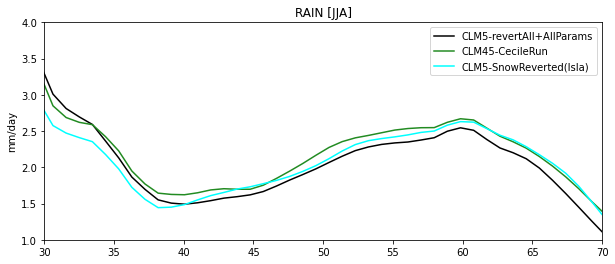

In [139]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

ax1.plot(smoothLat, lonMean_JJA_RAIN_clm5*86400, 'k', label='CLM5-revertAll+AllParams')
ax1.plot(smoothLat, lonMean_JJA_RAIN_clm45*86400, 'forestgreen', label='CLM45-CecileRun')
ax1.plot(smoothLat, lonMean_JJA_RAIN_clm5snow*86400,'cyan', label='CLM5-SnowReverted(Isla)')
ax1.set_title('RAIN [JJA]')
#ax1.set_xlim([-10,90])
ax1.set_xlim([30,70])
ax1.set_ylabel('mm/day')
ax1.set_ylim([1,4])
ax1.legend()
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')


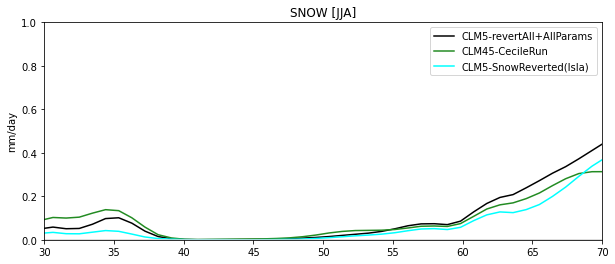

In [141]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

ax1.plot(smoothLat, lonMean_JJA_SNOW_clm5*86400, 'k', label='CLM5-revertAll+AllParams')
ax1.plot(smoothLat, lonMean_JJA_SNOW_clm45*86400, 'forestgreen', label='CLM45-CecileRun')
ax1.plot(smoothLat, lonMean_JJA_SNOW_clm5snow*86400,'cyan', label='CLM5-SnowReverted(Isla)')
ax1.set_title('SNOW [JJA]')
# ax1.set_xlim([-10,90])
ax1.set_xlim([30,70])
ax1.set_ylim([0,1])
ax1.set_ylabel('mm/day')
ax1.legend()
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')



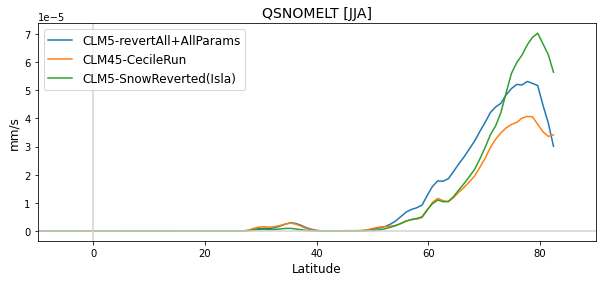

In [127]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

ax1.plot(smoothLat, lonMean_JJA_QSNOMELT_clm5, label='CLM5-revertAll+AllParams')
ax1.plot(smoothLat, lonMean_JJA_QSNOMELT_clm45, label='CLM45-CecileRun')
ax1.plot(smoothLat, lonMean_JJA_QSNOMELT_clm5snow, label='CLM5-SnowReverted(Isla)')
ax1.set_title('QSNOMELT [JJA]',fontsize=14)
ax1.set_xlim([-10,90])
ax1.set_ylabel('mm/s',fontsize=12)
ax1.set_xlabel('Latitude', fontsize=12)
ax1.legend(fontsize=12,loc='upper left')
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')




In [178]:
# Get zonal mean by season

lonMean_JJA_QIRRIG_clm5 = np.nanmean(np.nanmean(clm5_irrigDS.QIRRIG.values[iJJA_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
lonMean_JJA_QIRRIG_clm45 = np.nanmean(np.nanmean(clm45_irrigDS.QIRRIG.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)

# lonMean_JJA_SNOW_clm5 = np.nanmean(np.nanmean(clm5_precipDS.SNOW.values[iJJA_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
# lonMean_JJA_SNOW_clm45 = np.nanmean(np.nanmean(clm45cecile_precipDS.SNOW.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)
# lonMean_JJA_SNOW_clm5snow = np.nanmean(np.nanmean(clm5snow_precipDS.SNOW.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)


# Apply ~3˚ smoothing

lonMean_JJA_QIRRIG_clm5 = moving_average(lonMean_JJA_QIRRIG_clm5, w)
lonMean_JJA_QIRRIG_clm45 = moving_average(lonMean_JJA_QIRRIG_clm45, w)



<ipython-input-178-669f3393c719>:3: RuntimeWarning: Mean of empty slice
  lonMean_JJA_QIRRIG_clm5 = np.nanmean(np.nanmean(clm5_irrigDS.QIRRIG.values[iJJA_clm5,:,:],axis=0)*lndMask_notCyclic,axis=1)
<ipython-input-178-669f3393c719>:4: RuntimeWarning: Mean of empty slice
  lonMean_JJA_QIRRIG_clm45 = np.nanmean(np.nanmean(clm45_irrigDS.QIRRIG.values[iJJA_clm45,:,:],axis=0)*lndMask_notCyclic,axis=1)


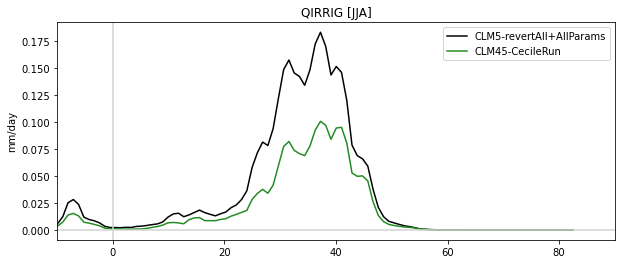

In [181]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

ax1.plot(smoothLat, lonMean_JJA_QIRRIG_clm5*86400.0, 'k', label='CLM5-revertAll+AllParams')
ax1.plot(smoothLat, lonMean_JJA_QIRRIG_clm45*86400.0, 'forestgreen', label='CLM45-CecileRun')
ax1.set_title('QIRRIG [JJA]')
ax1.set_xlim([-10,90])
#ax1.set_xlim([30,70])
#ax1.set_ylim([0,1])
ax1.set_ylabel('mm/day')
ax1.legend()
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')


### Look into param files for more details of differences?

In [76]:
paramFile_CLM5 = dataDir+'clm5_params.c171117.nc'
params_CLM5 = xr.open_dataset(paramFile_CLM5)

paramFile_CLM45 = dataDir+'clm_params.c170913.nc'
params_CLM45 = xr.open_dataset(paramFile_CLM45)


In [79]:
# Any difference in baset: "Base Temperature, parameter used in accFlds" ? 
params_CLM5['baset'].values - params_CLM45['baset'].values


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [107]:
diffParams = (params_CLM5-params_CLM45).isel(pft=np.arange(0,17))

In [108]:
print(diffParams)

<xarray.Dataset>
Dimensions:                     (allpfts: 1, pft: 17, segment: 4, variants: 2)
Coordinates:
    pftname                     (pft) |S40 b'not_vegetated                   ...
  * segment                     (segment) |S40 b'sunlit                      ...
Dimensions without coordinates: allpfts, pft, variants
Data variables:
    FUN_fracfixers              (pft) float64 -0.5 -0.25 -0.25 ... -0.5 -0.5
    a_fix                       (pft) float64 2.22e-15 2.22e-15 ... 2.22e-15
    aereoxid                    float64 0.0
    akc_active                  (pft) float64 -0.000489 0.05951 ... 0.05951
    akn_active                  (pft) float64 -0.0004383 0.1196 ... 0.1196
    aleaff                      (pft) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    allconsl                    (pft) float64 nan nan nan nan ... nan nan nan
    allconss                    (pft) float64 nan nan nan nan ... nan nan nan
    arootf                      (pft) float64 nan nan nan nan ... nan nan n

In [187]:
diffParams.crit_onset_swi

<xarray.DataArray 'crit_onset_swi' (allpfts: 1)>
array([0], dtype='timedelta64[ns]')
Dimensions without coordinates: allpfts

In [160]:
print('                       PFT                          slatop               psi50[0,pft]            mbbopt')
print('                      -----                    CLM4.5   CLM5.0       CLM4.5    CLM5.0       CLM4.5    CLM5.0')
print('                                              --------  -------     --------  --------     --------  --------')

for iPFT in range(17): 
    print( '%s : %7.4f %8.4f %12.1f %10.1f %11.4f %9.4f' % (diffParams.pftname.values[iPFT],params_CLM45.slatop[iPFT],params_CLM5.slatop[iPFT],
                                            params_CLM45.psi50[0,iPFT],params_CLM5.psi50[0,iPFT],
                                            params_CLM45.mbbopt[iPFT],params_CLM5.mbbopt[iPFT]) )
    
    

                       PFT                          slatop               psi50[0,pft]            mbbopt
                      -----                    CLM4.5   CLM5.0       CLM4.5    CLM5.0       CLM4.5    CLM5.0
                                              --------  -------     --------  --------     --------  --------
b'not_vegetated                           ' :  0.0000   0.0000          0.0  -150000.0      9.0000    9.0000
b'needleleaf_evergreen_temperate_tree     ' :  0.0100   0.0100    -200000.0  -530000.0      9.0000    4.4713
b'needleleaf_evergreen_boreal_tree        ' :  0.0080   0.0100    -200000.0  -400000.0      9.0000    7.1017
b'needleleaf_deciduous_boreal_tree        ' :  0.0240   0.0202    -200000.0  -380000.0      9.0000    7.1017
b'broadleaf_evergreen_tropical_tree       ' :  0.0120   0.0190    -200000.0  -250000.0      9.0000    7.2915
b'broadleaf_evergreen_temperate_tree      ' :  0.0120   0.0190    -200000.0  -270000.0      9.0000    7.1017
b'broadleaf_deciduous_t

In [189]:
# Proposal: Substitute CLM4.5 param values for a few interesting ones in CLM5

paramFile_CLM5revert = params_CLM5.copy(deep=True)

paramFile_CLM5revert['mbbopt'] = params_CLM45['mbbopt']
paramFile_CLM5revert['slatop'] = params_CLM45['slatop']
paramFile_CLM5revert['psi50']  = params_CLM45['psi50']


In [192]:
## Now convert to new netCDF file 
fileName = dataDir+'clm5_params.c171117_revert.mbbopt.slatop.psi50.nc'

paramFile_CLM5revert.to_netcdf(path=fileName, mode='w',format='NETCDF4_CLASSIC')


# What underlying variable has changed? Is it the std of SM, or the covariance of SM and SHFLX for the atmospheric leg?

CESM2 array with all variables: dFull <br>
CLM4.5+CAM6 array with all variables: dFull_CLM45


In [132]:
# Get JJA indices only 
dates_CESM2 = pd.DatetimeIndex(dFull['time'].values)
iJJA_CESM2  = np.where((dates_CESM2.month>=6) & (dates_CESM2.month<=8) )[0]
dFull_JJA = dFull.isel(time=iJJA_CESM2)
dates_CESM2 = dates_CESM2[iJJA_CESM2]

dates_CLM45 = pd.DatetimeIndex(dFull_CLM45['time'].values)
iJJA_CLM45  = np.where((dates_CLM45.month>=6) & (dates_CLM45.month<=8) )[0]
dFull_CLM45_JJA = dFull_CLM45.isel(time=iJJA_CLM45)
dates_CLM45 = dates_CLM45[iJJA_CLM45]


In [133]:
## Remove daily climatology for standard deviation
# -------------------------------------------------
SHflx_JJA_CESM2   = dFull_JJA['hfss'].values
soilM10_JJA_CESM2 = dFull_JJA['mrsos'].values

SHflx_JJA_CLM45   = dFull_CLM45_JJA['SHFLX'].values
soilM10_JJA_CLM45 = dFull_CLM45_JJA['soilM_10'].values

# Months and days per month 
monSel = np.asarray([6,   7,  8])
daySel = np.asarray([30, 31, 31])

# Empty array to save daily climo and the climo-removed data 
SHFLX_dailyClimo_CESM2   = np.full([92, len(lat), len(lon)], np.nan)
soilM10_dailyClimo_CESM2 = np.full([92, len(lat), len(lon)], np.nan)
SHFLX_dailyClimo_CLM45   = np.full([92, len(lat), len(lon)], np.nan)
soilM10_dailyClimo_CLM45 = np.full([92, len(lat), len(lon)], np.nan)

climoRemoved_SHFLX_CESM2 = np.full([np.shape(SHflx_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SoilM_CESM2 = np.full([np.shape(soilM10_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SHFLX_CLM45 = np.full([np.shape(SHflx_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SoilM_CLM45 = np.full([np.shape(soilM10_JJA_CESM2)[0], len(lat), len(lon)], np.nan)

# Let's also save std for each day 
dailySTD_SHFLX_CESM2     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SoilM_CESM2     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SHFLX_CLM45     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SoilM_CLM45     = np.full([92, len(lat), len(lon)], np.nan)

dayCounter = 0
for iMon in range(len(monSel)):
    for iDay in range(daySel[iMon]):
        # Pick out all days from this month in record 
        iSel_CESM2 = np.where((dates_CESM2.month==monSel[iMon]) & (dates_CESM2.day==(iDay+1)))[0]
        iSel_CLM45 = np.where((dates_CLM45.month==monSel[iMon]) & (dates_CLM45.day==(iDay+1)))[0]
        
        # Compute daily climo 
        dayClimo_SHflx_CESM2 = np.nanmean(SHflx_JJA_CESM2[iSel_CESM2,:,:],   axis=0)
        dayClimo_SoilM_CESM2 = np.nanmean(soilM10_JJA_CESM2[iSel_CESM2,:,:], axis=0)
        dayClimo_SHflx_CLM45 = np.nanmean(SHflx_JJA_CLM45[iSel_CLM45,:,:],   axis=0)
        dayClimo_SoilM_CLM45 = np.nanmean(soilM10_JJA_CLM45[iSel_CLM45,:,:], axis=0)
        
        # Save to file 
        SHFLX_dailyClimo_CESM2[dayCounter,:,:]   = dayClimo_SHflx_CESM2
        soilM10_dailyClimo_CESM2[dayCounter,:,:] = dayClimo_SoilM_CESM2
        SHFLX_dailyClimo_CLM45[dayCounter,:,:]   = dayClimo_SHflx_CLM45
        soilM10_dailyClimo_CLM45[dayCounter,:,:] = dayClimo_SoilM_CLM45
        
        # Remove climatology from record 
        for iSubtract in range(len(iSel_CESM2)):
            climoRemoved_SHFLX_CESM2[iSel_CESM2[iSubtract],:,:] = SHflx_JJA_CESM2[iSel_CESM2[iSubtract],:,:] - dayClimo_SHflx_CESM2
            climoRemoved_SoilM_CESM2[iSel_CESM2[iSubtract],:,:] = soilM10_JJA_CESM2[iSel_CESM2[iSubtract],:,:] - dayClimo_SoilM_CESM2
        for iSubtract in range(len(iSel_CLM45)):
            climoRemoved_SHFLX_CLM45[iSel_CLM45[iSubtract],:,:] = SHflx_JJA_CLM45[iSel_CLM45[iSubtract],:,:] - dayClimo_SHflx_CLM45
            climoRemoved_SoilM_CLM45[iSel_CLM45[iSubtract],:,:] = soilM10_JJA_CLM45[iSel_CLM45[iSubtract],:,:] - dayClimo_SoilM_CLM45
            
        # Save std of each JJA day 
        dailySTD_SHFLX_CESM2[dayCounter,:,:] = np.nanstd(SHflx_JJA_CESM2[iSel_CESM2,:,:],   axis=0)
        dailySTD_SoilM_CESM2[dayCounter,:,:] = np.nanstd(soilM10_JJA_CESM2[iSel_CESM2,:,:], axis=0)
        dailySTD_SHFLX_CLM45[dayCounter,:,:] = np.nanstd(SHflx_JJA_CLM45[iSel_CLM45,:,:],   axis=0)
        dailySTD_SoilM_CLM45[dayCounter,:,:] = np.nanstd(soilM10_JJA_CLM45[iSel_CLM45,:,:], axis=0)

        # Increment day of JJA counter
        dayCounter = dayCounter+1



<ipython-input-133-a28bca0c8a6d>:38: RuntimeWarning: Mean of empty slice
  dayClimo_SoilM_CESM2 = np.nanmean(soilM10_JJA_CESM2[iSel_CESM2,:,:], axis=0)
<ipython-input-133-a28bca0c8a6d>:40: RuntimeWarning: Mean of empty slice
  dayClimo_SoilM_CLM45 = np.nanmean(soilM10_JJA_CLM45[iSel_CLM45,:,:], axis=0)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [134]:
print('Mean of JJA daily std:    %.5f ' % np.nanmean(dailySTD_SHFLX_CESM2[:, 133, 203]))
print('Std of JJA climo removed: %.5f' % np.nanstd(climoRemoved_SHFLX_CESM2[:,133,203], axis=0))


Mean of JJA daily std:    20.49760 
Std of JJA climo removed: 21.52787


Text(0.5, 1.0, 'CESM2: Sanity check on daily climo removal')

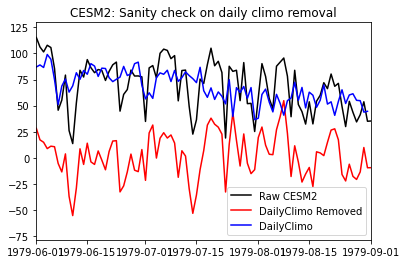

In [138]:
# Quick plot to confirm that this *is* working about how I think it should

plt.plot(dates_CESM2, SHflx_JJA_CESM2[:,133,203], 'k-')
plt.plot(dates_CESM2, climoRemoved_SHFLX_CESM2[:,133,203], 'r-')
plt.plot(dates_CESM2[0:92],SHFLX_dailyClimo_CESM2[:,133,203],'b-')

plt.xlim([datetime.date(1979,6,1), datetime.date(1979,9,1)])
plt.legend(['Raw CESM2', 'DailyClimo Removed', 'DailyClimo'])
plt.title('CESM2: Sanity check on daily climo removal')


In [139]:
# Now get mean and std of soil moisture and sensible heat flux 
SM_JJAmean_CESM2 = np.nanmean(soilM10_JJA_CESM2, axis=0)
SM_JJAmean_CLM45 = np.nanmean(soilM10_JJA_CLM45, axis=0)

SH_JJAmean_CESM2 = np.nanmean(SHflx_JJA_CESM2, axis=0)
SH_JJAmean_CLM45 = np.nanmean(SHflx_JJA_CLM45, axis=0)

# For std especially, remove daily climatology from data 
SM_JJAstd_CESM2  = np.nanstd(climoRemoved_SoilM_CESM2, axis=0)
SM_JJAstd_CLM45  = np.nanstd(climoRemoved_SoilM_CLM45, axis=0)

SH_JJAstd_CESM2  = np.nanstd(climoRemoved_SHFLX_CESM2, axis=0)
SH_JJAstd_CLM45  = np.nanstd(climoRemoved_SHFLX_CLM45, axis=0)


<ipython-input-139-b266eb21cfa9>:2: RuntimeWarning: Mean of empty slice
  SM_JJAmean_CESM2 = np.nanmean(soilM10_JJA_CESM2, axis=0)
<ipython-input-139-b266eb21cfa9>:3: RuntimeWarning: Mean of empty slice
  SM_JJAmean_CLM45 = np.nanmean(soilM10_JJA_CLM45, axis=0)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [146]:
# Compute variances and isolate Plcl
Plcl_JJA_CESM2    = dFull_JJA['Plcl'].values
Plcl_JJA_CLM45    = dFull_CLM45_JJA['Plcl'].values

averaging = "season"
from comet.metrics import utils as gf

# --------------------------------------------------------------
# Follow steps from Ahmed's CoMeT computation of coupling index: 
# --------------------------------------------------------------

# --- CESM 2 ----- 
xname     = "mrsos"
yname     = "hfss"

# Get time axis name
time_dim = gf.get_time_axis_name(dFull)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = dFull[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = dFull[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCESM2_terra = gf.covariance(xday,yday,dim)

# Atmo leg
xname     = "hfss"
yname     = "Plcl"

# Get time axis name
time_dim = gf.get_time_axis_name(dFull)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = dFull[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = dFull[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCESM2_atmo = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CESM2')

# --- CLM4.5+CAM6 ----- 
xname     = "soilM_10"
yname     = "SHFLX"

# Get time axis name
time_dim = gf.get_time_axis_name(dFull_CLM45)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = dFull_CLM45[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = dFull_CLM45[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCLM45_terra = gf.covariance(xday,yday,dim)

# Atmo leg
xname     = "SHFLX"
yname     = "Plcl"

# Get time axis name
time_dim = gf.get_time_axis_name(dFull_CLM45)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = dFull_CLM45[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = dFull_CLM45[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCLM45_atmo = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CLM45')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty sli

Done with CESM2


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty sli

Done with CLM45


In [148]:
# ------------------------------------------------------
#   Compute zonal means of variables 
#     First, average over JJA. Then average over longitude
# ------------------------------------------------------

# ----- SHFLX -----
shflx_CESM2_JJA = np.nanmean(SHflx_JJA_CESM2,axis=0)  # Average over JJA 
shflx_CLM45_JJA = np.nanmean(SHflx_JJA_CLM45,axis=0)

lonMean_shflx_CESM2 = np.nanmean(shflx_CESM2_JJA*lndMask_notCyclic,axis=1) # Average over longitude 
lonMean_shflx_CLM45 = np.nanmean(shflx_CLM45_JJA*lndMask_notCyclic,axis=1)
# -----------------

# ----- SoilM_10CM -----
soilm_CESM2_JJA = np.nanmean(soilM10_JJA_CESM2,axis=0)  # Average over JJA 
soilm_CLM45_JJA = np.nanmean(soilM10_JJA_CLM45,axis=0)

lonMean_soilm_CESM2 = np.nanmean(soilm_CESM2_JJA*lndMask_notCyclic,axis=1) # Average over longitude 
lonMean_soilm_CLM45 = np.nanmean(soilm_CLM45_JJA*lndMask_notCyclic,axis=1)
# ---------------------

# ----- Plcl -----
plcl_CESM2_JJA = np.nanmean(Plcl_JJA_CESM2,axis=0)  # Average over JJA 
plcl_CLM45_JJA = np.nanmean(Plcl_JJA_CLM45,axis=0)

lonMean_plcl_CESM2 = np.nanmean(plcl_CESM2_JJA*lndMask_notCyclic,axis=1) # Average over longitude 
lonMean_plcl_CLM45 = np.nanmean(plcl_CLM45_JJA*lndMask_notCyclic,axis=1)
# -----------------

# ----- Covar(SM, SHFLX) -----
covarTerra_CESM2_JJA = covarCESM2_terra[1,:,:]  # Select JJA season 
covarTerra_CLM45_JJA = covarCLM45_terra[1,:,:]

lonMean_covarTerra_CESM2 = np.nanmean(covarTerra_CESM2_JJA*lndMask_notCyclic,axis=1) # Average over longitude 
lonMean_covarTerra_CLM45 = np.nanmean(covarTerra_CLM45_JJA*lndMask_notCyclic,axis=1)
# -----------------------------

# ----- Covar(SHFLX, Plcl) -----
covarAtmo_CESM2_JJA = covarCESM2_atmo[1,:,:]    # Select JJA season 
covarAtmo_CLM45_JJA = covarCLM45_atmo[1,:,:]

lonMean_covarAtmo_CESM2 = np.nanmean(covarAtmo_CESM2_JJA*lndMask_notCyclic,axis=1) # Average over longitude 
lonMean_covarAtmo_CLM45 = np.nanmean(covarAtmo_CLM45_JJA*lndMask_notCyclic,axis=1)
# -----------------------------

# ----- std(SHFLX) -----
lonMean_StdShflx_CESM2 = np.nanmean(SH_JJAstd_CESM2*lndMask_notCyclic,axis=1) # Average over longitude 
lonMean_StdShflx_CLM45 = np.nanmean(SH_JJAstd_CLM45*lndMask_notCyclic,axis=1)
# ----------------------

# ----- std(SM) -----
lonMean_StdSoilm_CESM2 = np.nanmean(SM_JJAstd_CESM2*lndMask_notCyclic,axis=1) # Average over longitude 
lonMean_StdSoilm_CLM45 = np.nanmean(SM_JJAstd_CLM45*lndMask_notCyclic,axis=1)
# ----------------------



<ipython-input-148-ea9761696bbe>:10: RuntimeWarning: Mean of empty slice
  lonMean_shflx_CESM2 = np.nanmean(shflx_CESM2_JJA*lndMask_notCyclic,axis=1) # Average over longitude
<ipython-input-148-ea9761696bbe>:11: RuntimeWarning: Mean of empty slice
  lonMean_shflx_CLM45 = np.nanmean(shflx_CLM45_JJA*lndMask_notCyclic,axis=1)
<ipython-input-148-ea9761696bbe>:15: RuntimeWarning: Mean of empty slice
  soilm_CESM2_JJA = np.nanmean(soilM10_JJA_CESM2,axis=0)  # Average over JJA
<ipython-input-148-ea9761696bbe>:16: RuntimeWarning: Mean of empty slice
  soilm_CLM45_JJA = np.nanmean(soilM10_JJA_CLM45,axis=0)
<ipython-input-148-ea9761696bbe>:18: RuntimeWarning: Mean of empty slice
  lonMean_soilm_CESM2 = np.nanmean(soilm_CESM2_JJA*lndMask_notCyclic,axis=1) # Average over longitude
<ipython-input-148-ea9761696bbe>:19: RuntimeWarning: Mean of empty slice
  lonMean_soilm_CLM45 = np.nanmean(soilm_CLM45_JJA*lndMask_notCyclic,axis=1)
<ipython-input-148-ea9761696bbe>:23: RuntimeWarning: Mean of empty sli

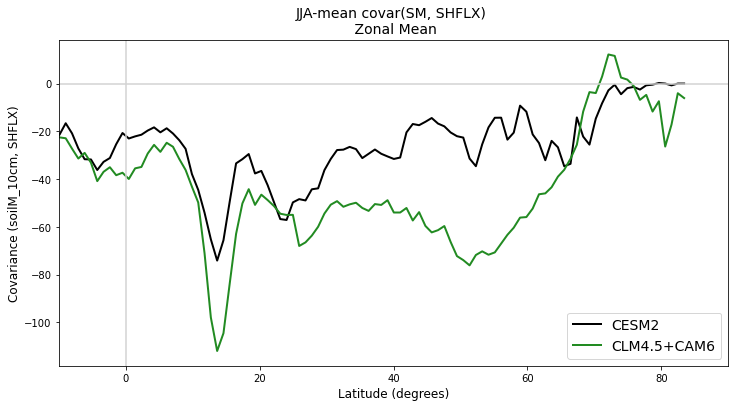

In [153]:
# ------------------------------------------------------
#  Now plot zonal mean of selected variable. 
#  Valid choices for 'varPlot' are: 'shflx', 'soilM_10',
#     'Plcl', 'covar_terra', 'covar_atmo', 'shflx_std', 
#     'soilM_10_std'
# ------------------------------------------------------

# DEFINE VARIABLE HERE 
varPlot = 'covar_terra'

# ------ Define data arrays to be plotted ------
if varPlot == 'shflx':
    lonMean_CESM2 = lonMean_shflx_CESM2
    lonMean_CLM45 = lonMean_shflx_CLM45
    # A few plot options to specify 
    pltTitle = 'JJA-mean SHFLX \n Zonal Mean'
    yTitle   = 'SHFLX [W/m2]' 
elif varPlot == 'soilM_10':
    lonMean_CESM2 = lonMean_soilm_CESM2
    lonMean_CLM45 = lonMean_soilm_CLM45
    # A few plot options
    pltTitle = 'JJA-mean soilM_10cm \n Zonal Mean'
    yTitle   = '10cm Soil Moisture [kg/m2]'
elif varPlot == 'Plcl':
    lonMean_CESM2 = lonMean_plcl_CESM2
    lonMean_CLM45 = lonMean_plcl_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean P_lcl \n Zonal Mean'
    yTitle   = 'Pressure level of the LCL [hPa above the surface]'
elif varPlot == 'covar_terra':
    lonMean_CESM2 = lonMean_covarTerra_CESM2
    lonMean_CLM45 = lonMean_covarTerra_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean covar(SM, SHFLX) \n Zonal Mean'
    yTitle   = 'Covariance (soilM_10cm, SHFLX)'
elif varPlot == 'covar_atmo':
    lonMean_CESM2 = lonMean_covarAtmo_CESM2
    lonMean_CLM45 = lonMean_covarAtmo_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean covar(SHFLX, P_lcl) \n Zonal Mean'
    yTitle   = 'Covariance (SHFLX, P_lcl)'
elif varPlot == 'shflx_std':
    lonMean_CESM2 = lonMean_StdShflx_CESM2
    lonMean_CLM45 = lonMean_StdShflx_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean std(SHFLX) \n Zonal Mean'
    yTitle   = 'Standard deviation of SHFLX (daily climo removed)'
elif varPlot == 'soilM_10_std':
    lonMean_CESM2 = lonMean_StdSoilm_CESM2
    lonMean_CLM45 = lonMean_StdSoilm_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean std(soilM_10cm) \n Zonal Mean'
    yTitle   = 'Standard deviation of soilM (daily climo removed)'
else:
    print('***** Please select available zonal mean variable to plot ******')

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,lonMean_CESM2,'k', linewidth=2)
ax1.plot(lat,lonMean_CLM45,'forestgreen', linewidth=2)

#ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'])
ax1.legend(['CESM2','CLM4.5+CAM6'], fontsize=14)
ax1.set_xlabel('Latitude (degrees)',fontsize=12)
ax1.set_ylabel(yTitle,fontsize=12)
ax1.set_title(pltTitle, fontsize=14)
ax1.set_xlim([-10, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')